In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Objectives

Course4U grows rapidly and reaches millions of learners in a very short period. The learning topics of AI Training Room can be summarized in the following word cloud:
​
<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_1/images/word_cloud.png" width="600" alt="word cloud">
<center>

Starting this year, machine learning engineer team is working very hard on a recommender system project. **The main goal of this project is to improve learners’ learning experience via helping them quickly find new interested courses and better paving their learning paths**. Meanwhile, **with more learners interacting with more courses via C4U recommender systems,C4U company’s revenue may also be increased**.

This project is currently at the *Proof of Concept (PoC) phase* so your **main focus at this moment is to explore and compare various machine learning models and find one with the best performance in off-line evaluations.**

In Part 1 (P01), we elaborate on a content-based recommender system using unsupervised learning, where we utilize user profiles and course genres. In <a href="https://www.kaggle.com/wahyuardhitama/task003-p002-ml-dl-rec-sys-course-20231029">part 2 (P02)</a>, we explore clustering-based recommender system using unsupervised learning. Finally, in the last part,<a href="https://www.kaggle.com/wahyuardhitama/task003-p003-ml-dl-rec-sys-course-20231101"> part 3 (P03)</a>, we take a deep dive into a content-based recommender system using supervised learning.

### Note: 
This project's dataset was created for pedagogical purposes and may not represent real-world data. The project consists of multiple notebook parts, focusing on combining data from various tables and conducting data analysis and prediction to acquire valuable insights.


## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li><a href="#Import">Import the relevant libraries</a></li>
    <li><a href="#Cleaning">Data Cleaning</a></li>
    <li><a href="#EDA">Exploration Data Analysis (EDA)</a></li>
    <ol>
        <li><a href="#Course_Gen">Data exploration: Analyze course genres</a></li>
        <li><a href="#Course_Enroll">Data exploration: Analyze course enrollments</a></li>
        <li><a href="#Top_Courses">Data exploration: Top-20 most popular courses</a></li>
        <li><a href="#BoW_1">Data exploration: Bag of Word</a></li>
    </ol>
    <li><a href="#SIM_1">Find similar courses</a></li>
    <ol>
        <li><a href="#SIM_1">To the course Machine Learning with Python ( 1 course with 1 course)</a></li>
        <li><a href="#SIM_2">To the chosen course (1 course with other courses)</a></li>
    </ol>
    <li><a href="#Con_Rec">Generate course recommendations based on user profile and course genre vectors</a></li>
    <ol>
        <li><a href="#Cal_1">Calculate the recommendation scores of all courses for all (1000) test users</a></li>
        <li><a href="#Res_1">Result course recommendation for 3 users based on user profile and course genre</a></li>
    </ol>
    <li><a href="#Con_Rec_Sim">Content-based Course Recommender System using Course Similarities</a></li>
    <ol>
        <li><a href="#Sea_1">Search courses which are similar enough to your enrolled courses</a></li>
        <li><a href="#Sea_2">Generate course recommendations based on course similarities for all (1000) test users</a></li>
        <li><a href="#Res_2">Result course recommendation for 3 users based on course similarities</a></li>
    </ol>
    
</ol>

In [2]:
pip show wordcloud

Name: wordcloud
Version: 1.9.2
Summary: A little word cloud generator
Home-page: https://github.com/amueller/word_cloud
Author: Andreas Mueller
Author-email: t3kcit+wordcloud@gmail.com
License: MIT
Location: /opt/conda/lib/python3.10/site-packages
Requires: matplotlib, numpy, pillow
Required-by: ydata-profiling
Note: you may need to restart the kernel to use updated packages.


<img style="float:left" src="https://i.imgur.com/gIne5bH.png" width="80">

<h1><a id="Import">Import the Relevant Libraries</a></h1>

In [3]:
#Setup
import warnings
#import skillsnetwork

warnings.filterwarnings("ignore")
# For data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For displaying and words plotting
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Sets backend to render higher res images
sns.set_style("whitegrid")
sns.set_context("notebook")

In [4]:
# also set a random state
rs = 123

In [5]:
## Preprocessing
### Load the data
course_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_genre.csv"
ratings_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"

In [6]:
course_df = pd.read_csv(course_genre_url)
ratings_df = pd.read_csv(ratings_url)

In [7]:
course_df.columns

Index(['COURSE_ID', 'TITLE', 'Database', 'Python', 'CloudComputing',
       'DataAnalysis', 'Containers', 'MachineLearning', 'ComputerVision',
       'DataScience', 'BigData', 'Chatbot', 'R', 'BackendDev', 'FrontendDev',
       'Blockchain'],
      dtype='object')

In [8]:
course_df.shape[0]

307

Course4U offers 307 courses. 

In [9]:
course_df.head()

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,ML0201EN,robots are coming build iot apps with watson ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,ML0122EN,accelerating deep learning with gpu,0,1,0,0,0,1,0,1,0,0,0,0,0,0
2,GPXX0ZG0EN,consuming restful services using the reactive ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,RP0105EN,analyzing big data in r using apache spark,1,0,0,1,0,0,0,0,1,0,1,0,0,0
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [10]:
course_df.dtypes

COURSE_ID          object
TITLE              object
Database            int64
Python              int64
CloudComputing      int64
DataAnalysis        int64
Containers          int64
MachineLearning     int64
ComputerVision      int64
DataScience         int64
BigData             int64
Chatbot             int64
R                   int64
BackendDev          int64
FrontendDev         int64
Blockchain          int64
dtype: object

As we can see, the `COURSE_ID` and `TITLE` are `str` datatypes and all the course genres are binary/int datatypes. Any genre column with value 1 means the course is associated with the course genre while 0 means the course is not.

In [11]:
course_df.iloc[1, ]

COURSE_ID                                     ML0122EN
TITLE              accelerating deep learning with gpu
Database                                             0
Python                                               1
CloudComputing                                       0
DataAnalysis                                         0
Containers                                           0
MachineLearning                                      1
ComputerVision                                       0
DataScience                                          1
BigData                                              0
Chatbot                                              0
R                                                    0
BackendDev                                           0
FrontendDev                                          0
Blockchain                                           0
Name: 1, dtype: object

For example above, the following course `accelerating deep learning with gpu` is associated with genres `Python`, `MachineLearning`, and `DataScience`


<h1><a id="Cleaning">Data Cleaning</a></h1>

<Axes: >

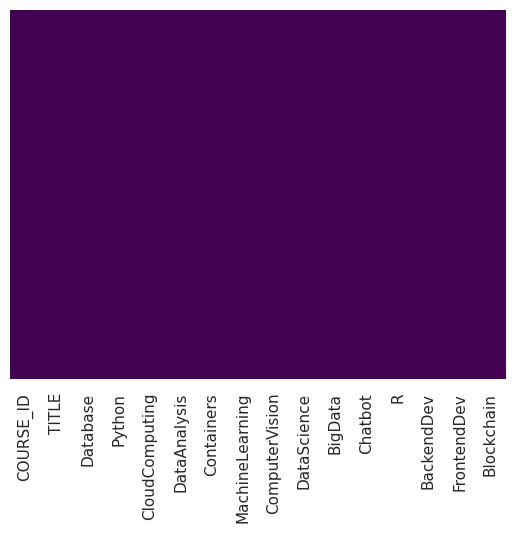

In [12]:
# Data Cleaning
sns.heatmap(course_df.isna(), yticklabels=False,cbar=False,cmap='viridis')

In [13]:
course_df.duplicated().mean()*100

0.0

<img style="float:left" src="https://i.imgur.com/rb8V6X5.png" width="50">

<h1><a id="Import">Import the Relevant Libraries</a></h1><h1><a id="EDA">Exploration Data Analysis (EDA)</a></h1>

### Plot a word cloud from course titles
First, let's join all the title values into one string, then we can conveniently get a wordcloud from the big string:


In [14]:
titles = " ".join(title for title in course_df['TITLE'].astype(str))

In [15]:
titles

'robots are coming  build iot apps with watson  swift  and node red accelerating deep learning with gpu consuming restful services using the reactive jax rs client analyzing big data in r using apache spark containerizing  packaging  and running a spring boot application cloud native security conference  data security data science bootcamp with r for university proffesors learn how to use docker containers for iterative development scorm test course create your first mongodb database testing microservices with the arquillian managed container cloud pak for integration essentials watson analytics for social media data science bootcamp with python for university professors  advance create a cryptocurrency trading algorithm in python data   ai essentials securing java microservices with eclipse microprofile json web token  microprofile jwt  enabling distributed tracing in microservices with zipkin sql access for hadoop ybrid cloud conference  ai pipelines lab dataops methodology data   ai

We also want to filter common stop words and some less meaningful words:

In [16]:
# English Stopwords
stopwords = set(STOPWORDS)
stopwords.update(["getting started", "using", "enabling", "template", "university", "end", "introduction", "basic"])

Then, we create a ```WordCloud``` object and generate ```wordcloud``` from the titles.

In [17]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400)

In [18]:
wordcloud.generate(titles)

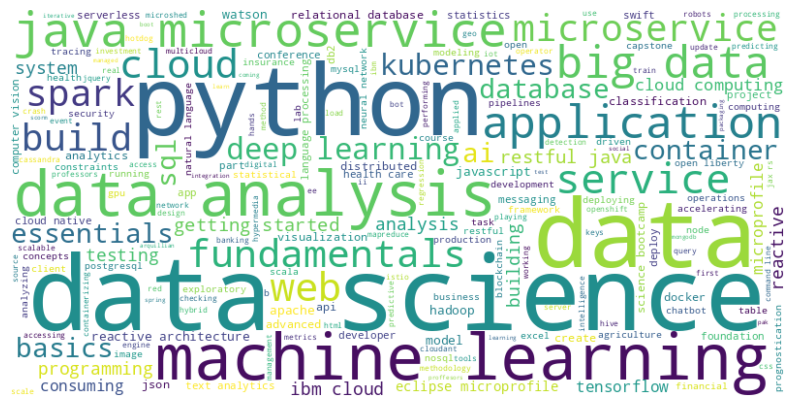

In [19]:
# Set the figure size and axis properties
plt.figure(figsize=(10,20))
plt.tight_layout(pad=0)
plt.axis("off")
# Display the image
plt.imshow(wordcloud, interpolation='bilinear')
#plt.savefig('1_WorldCloud1.png', dpi=200, bbox_inches = "tight")
plt.show()

<div class="alert alert-block alert-info">
<img style="float: left" src="https://i.imgur.com/HVpiyd6.png[/img" width="60">
<b style = "font-family: Arial; font-size: 16px">Results:</b><p style = "font-family:Verdana; font-size:14px">

As we can see from the `wordcloud`,  there are many popular IT related keywords such as python, data science, machine learning, big data, ai, tensorflow, container, cloud, etc. By looking at these keywords, we should have a general understanding that the courses in the dataset are focused on demanding IT skills.

<h2><a id="Course_Gen">Data exploration: Analyze course genres</a></h2>

Choose and find out which courses of interest. For example, what are the all machine learning in `MachineLearning` related courses?

In [20]:
course_df[course_df['MachineLearning'] == 1].head(5)

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
1,ML0122EN,accelerating deep learning with gpu,0,1,0,0,0,1,0,1,0,0,0,0,0,0
15,DAI101EN,data ai essentials,0,0,0,0,0,1,0,0,0,0,0,0,0,0
19,HCC105EN,ybrid cloud conference ai pipelines lab,0,0,0,0,0,1,0,0,0,0,0,0,0,0
21,DS0132EN,data ai jumpstart your journey,0,0,0,0,0,1,0,0,0,0,0,0,0,0
24,BENTEST4,ai for everyone master the basics,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [21]:
ml_course=course_df[course_df['MachineLearning'] == 1]
ml_course.shape

(69, 16)

There are 69 courses related to `MachineLearning`. Some of those courses are also correlated to other genres. For example `COURSE_ID` ML1022EN also related to `Python` and `DataScience`

In [22]:
course_df[course_df['BigData'] == 1].head(5)

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
3,RP0105EN,analyzing big data in r using apache spark,1,0,0,1,0,0,0,0,1,0,1,0,0,0
18,BD0145EN,sql access for hadoop,1,0,0,0,0,0,0,0,1,0,0,0,0,0
29,TMP0105EN,getting started with the data apache spark ma...,1,0,0,1,0,0,0,0,1,0,0,0,0,0
37,BD0212EN,spark fundamentals ii,1,0,0,1,0,0,0,0,1,0,0,0,0,0
40,SC0103EN,spark overview for scala analytics,1,0,0,1,0,0,0,0,1,0,0,0,0,0


In [23]:
bd_course=course_df[course_df['BigData'] == 1]
bd_course.shape

(36, 16)

There are 36 courses related to `BigData`. Some of those courses are also correlated to other genres. For example `COURSE_ID` RP0105EN also related to `Database`, `DataAnalysis` and `R` 

In [24]:
# Create genres columns
genres = course_df.columns[2:]
genres

Index(['Database', 'Python', 'CloudComputing', 'DataAnalysis', 'Containers',
       'MachineLearning', 'ComputerVision', 'DataScience', 'BigData',
       'Chatbot', 'R', 'BackendDev', 'FrontendDev', 'Blockchain'],
      dtype='object')

In [25]:
# Elaborate how many courses related to each genres
course_df[genres].sum(axis=0)

Database           60
Python             28
CloudComputing     37
DataAnalysis       56
Containers         17
MachineLearning    69
ComputerVision     10
DataScience        38
BigData            36
Chatbot             4
R                  17
BackendDev         78
FrontendDev        19
Blockchain          4
dtype: int64

In [26]:
genre_sums = course_df[genres].sum(axis=0)

In [27]:
df_1 = pd.DataFrame(genre_sums, columns = ['Count'])
df_1

,Count
Database,60
Python,28
CloudComputing,37
DataAnalysis,56
Containers,17
MachineLearning,69
ComputerVision,10
DataScience,38
BigData,36
Chatbot,4


In [28]:
df_1 = df_1.sort_values(by = "Count", ascending=False)
df_1

,Count
BackendDev,78
MachineLearning,69
Database,60
DataAnalysis,56
DataScience,38
CloudComputing,37
BigData,36
Python,28
FrontendDev,19
Containers,17


In [29]:
total_count = df_1['Count'].sum()
total_count

473

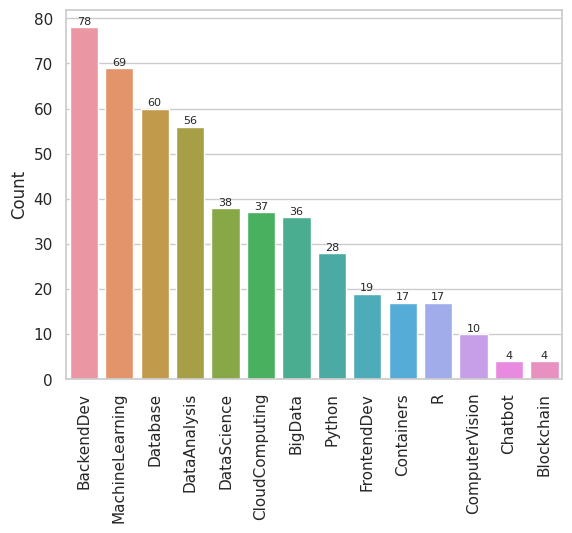

In [30]:
plot = sns.barplot(x=df_1.index, y="Count", data=df_1)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

# Add labels on top of the bars
for index, value in enumerate(df_1['Count']):
    plot.text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=8)

# Display the plot and suppress text output
#plt.savefig('2_Courses_genres_offer_1.png', dpi=200, bbox_inches = "tight")
plt.show()

<div class="alert alert-block alert-info">
<img style="float: left" src="https://i.imgur.com/HVpiyd6.png[/img" width="60">
<b style = "font-family: Arial; font-size: 16px">Results:</b><p style = "font-family:Verdana; font-size:14px">
    
From the bar plot, we can infer that, starting from the left, C4U offers courses that are mostly related to the `BackendDev` and `MachineLearning` genres, and so on, with the least representation of the courses related to the `Chatbot` and `Blockchain` genres on the right side of the graph. Remember, there are 307 courses offered, not 473 courses; the later imply some of these courses are also related to other genres.</p> 

<h2><a id="Course_Enroll">Data exploration: Analyze course enrollments</a></h2>

Explore course enrollments dataset

In [31]:
ratings_df.columns

Index(['user', 'item', 'rating'], dtype='object')

In [32]:
ratings_df.shape[0]

233306

In [33]:
ratings_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [34]:
ratings_df['rating'].unique()

array([3., 2.])

<div class="alert alert-block alert-warning">
<img style="float: left" src="https://i.postimg.cc/kXz8cFqC/005-Img-Yellow-Notes-Draft-1-20220819.png" width="60">
<b style = "font-family: Arial; font-size: 16px">Note:</b>
    
The rating column contains one of two values: `2` means the user just audited the course without completing it and `3` means the user completed the course and earned a certificate.
Two other possible values are not explicitly available in this project: `0` or `NA` means the user has no interaction with the course and `1` means the user just browsed the course.    
</div>



### Data cleaning

<Axes: >

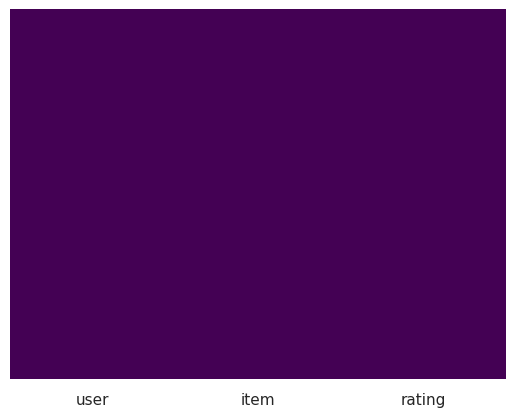

In [35]:
# Data Cleaning
sns.heatmap(ratings_df.isna(), yticklabels=False,cbar=False,cmap='viridis')

In [36]:
ratings_df.duplicated().mean()*100

0.0

### Continue exploration

In [37]:
# Total aggregrate the rating count of each user
ratings_df.groupby('user')['rating'].count().sort_values(ascending=False).head(10)

user
2          61
5          59
924030     51
1653994    51
1761291    50
1559851    50
382781     50
746163     50
971917     50
1445103    49
Name: rating, dtype: int64

In [38]:
# Total aggregrate the rating mean of each user
ratings_df.groupby('user')['rating'].mean().sort_values(ascending=False).head(10)

user
904648     3.0
1059026    3.0
1059213    3.0
1588326    3.0
1588471    3.0
1059146    3.0
1059141    3.0
1059132    3.0
1588494    3.0
1588553    3.0
Name: rating, dtype: float64

In [39]:
ratings_df.groupby('user')['item'].count().shape

(33901,)

In [40]:
# Report the total number of users after aggregation
total_users = len(ratings_df.groupby('user')['item'].count())
print("\nTotal number of users after aggregation:", total_users)


Total number of users after aggregation: 33901


In [41]:
user_ratings= pd.DataFrame(ratings_df.groupby('user')['rating'].mean())

In [42]:
user_ratings.head(5)

,rating
user,
2,2.704918
4,2.000000
5,2.000000
7,2.000000
8,2.000000


In [43]:
user_ratings['enrollments']= pd.DataFrame(ratings_df.groupby('user')['item'].count())

In [44]:
user_ratings.describe()

,rating,enrollments
count,33901.000000,33901.000000
mean,2.735414,6.881980
std,0.439103,5.823548
min,2.000000,1.000000
25%,2.000000,2.000000
50%,3.000000,6.000000
75%,3.000000,9.000000
max,3.000000,61.000000


In [45]:
user_ratings.head(5)

,rating,enrollments
user,,
2,2.704918,61
4,2.000000,44
5,2.000000,59
7,2.000000,1
8,2.000000,3


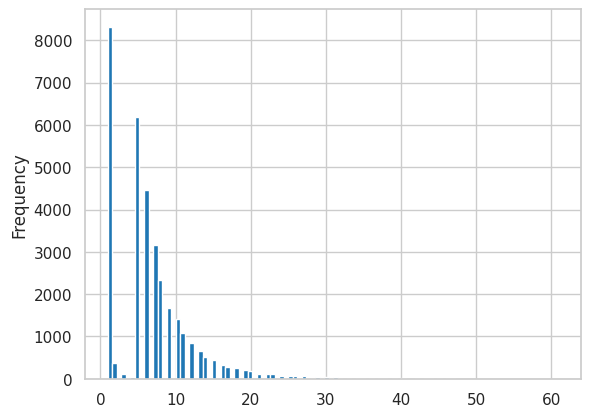

In [46]:
# Plot histogram how many user's in range of enrollments
user_ratings['enrollments'].plot.hist(bins=100)
#plt.savefig('particpants_enrollments.png', dpi=200, bbox_inches = "tight")
plt.show()

In [47]:
user_ratings[user_ratings['enrollments'] == 11]['enrollments'].count()

1093

In [48]:
user_ratings[user_ratings['enrollments'] == 1]['enrollments'].count()

8320

In [49]:
user_ratings[user_ratings['enrollments'] == 50]['enrollments'].count()

5

<div class="alert alert-block alert-info">
<img style="float: left" src="https://i.imgur.com/HVpiyd6.png[/img" width="60">
<b style = "font-family: Arial; font-size: 16px">Results:</b><p style = "font-family:Verdana; font-size:14px">
    
The enrollment distribution of participants is right-skewed, indicating a continuous decline. The histogram reveals that a majority of participants of over 1,000 participants have enrolled between 1 to around 11 times. At least 8,320 participants have enrolled in one course, and a notable drop occurs in enrollments ranging from 2 to 4. There is a surge in participation, with over 6,000 participants enrolling in 5 courses, followed by a continuous decline as the number of enrollments increases.</p> 

<h2><a id="Top_Courses">Data exploration: Top-20 most popular courses</a></h2>

In [50]:
ratings_df.groupby('item')['rating'].count()

item
AI0111EN       383
BC0101EN      6719
BC0201EN      2866
BC0202EN       775
BD0101EN     13291
             ...  
TMP0105EN      347
TMP0106         35
TMP107           2
WA0101EN      2247
WA0103EN        56
Name: rating, Length: 126, dtype: int64

In [51]:
item_enroll = pd.DataFrame(ratings_df.groupby('item')['rating'].size().reset_index())

In [52]:
item_enroll.columns = ['item', 'Enrolls']
item_enroll

,item,Enrolls
0,AI0111EN,383
1,BC0101EN,6719
2,BC0201EN,2866
3,BC0202EN,775
4,BD0101EN,13291
...,...,...
121,TMP0105EN,347
122,TMP0106,35
123,TMP107,2
124,WA0101EN,2247


In [53]:
title_enrolls= pd.merge(course_df[['COURSE_ID', 'TITLE']], item_enroll[['item', 'Enrolls']], left_on='COURSE_ID', right_on='item', 
                        how='left')[['TITLE', 'Enrolls']]
title_enrolls

,TITLE,Enrolls
0,robots are coming build iot apps with watson ...,529.0
1,accelerating deep learning with gpu,270.0
2,consuming restful services using the reactive ...,NaN
3,analyzing big data in r using apache spark,1124.0
4,containerizing packaging and running a sprin...,NaN
...,...,...
302,javascript jquery and json,NaN
303,programming foundations with javascript html ...,NaN
304,front end web development with react,NaN
305,introduction to web development,NaN


<Axes: >

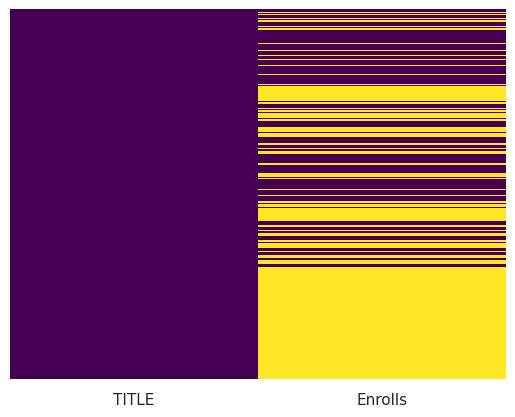

In [54]:
# Data Cleaning
sns.heatmap(title_enrolls.isna(), yticklabels=False,cbar=False,cmap='viridis')

In [55]:
title_enrolls.isna().mean()

TITLE      0.000000
Enrolls    0.589577
dtype: float64

In [56]:
# Drop columns with missing values
title_enrolls = title_enrolls.dropna()

In [57]:
title_enrolls.head()

,TITLE,Enrolls
0,robots are coming build iot apps with watson ...,529.0
1,accelerating deep learning with gpu,270.0
3,analyzing big data in r using apache spark,1124.0
5,cloud native security conference data security,1838.0
6,data science bootcamp with r for university pr...,1.0


In [58]:
title_enrolls.describe().T

,count,mean,std,min,25%,50%,75%,max
Enrolls,126.0,1851.634921,2874.579272,1.0,212.25,634.0,2247.0,14936.0


In [59]:
# Sort the values in descending order by 'Ratings'
top_20_courses = title_enrolls.sort_values(ascending=False, by='Enrolls').reset_index(drop=True).head(20)

# Display the top 20 courses
top_20_courses

,TITLE,Enrolls
0,python for data science,14936.0
1,introduction to data science,14477.0
2,big data 101,13291.0
3,hadoop 101,10599.0
4,data analysis with python,8303.0
5,data science methodology,7719.0
6,machine learning with python,7644.0
7,spark fundamentals i,7551.0
8,data science hands on with open source tools,7199.0
9,blockchain essentials,6719.0


In [60]:
# Get the total course enrollments again
total = title_enrolls['Enrolls'].values.sum()
total

233306.0

In [61]:
# WRITE YOUR CODE HERE
top = top_20_courses['Enrolls'].values.sum()
top

147688.0

In [62]:
print(f"Percentage of the top course enrollments {round((top * 100)/total, 2)}%")

Percentage of the top course enrollments 63.3%


In [63]:
course_df.shape[0]

307

In [64]:
print(f"Percentage of the 20 course  {round((20 * 100)/course_df.shape[0], 2)}%")

Percentage of the 20 course  6.51%


In [65]:
# Get the total course enrollments again
count_course = title_enrolls['TITLE'].count()
count_course

126

In [66]:
print(f"Percentage of the courses enrolled  {round((count_course * 100)/course_df.shape[0], 2)}%")

Percentage of the courses enrolled  41.04%


<h3 style = "text-align:center">Table 1.1. Project Charter</h3>
<table style="color:black;
           display:fill;
           border-colapse: colapse;
           width: 100%;
           border: 1px solid black;
           border-collapse: collapse;
           border-style: solid;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
  
  <tr>
    <th colspan ="4" style="text-align:center">Project Recommender System</th>
  </tr>
    <tr>
    <th colspan ="4" style="text-align:center">25th Oct 2023</th>
  </tr>
  <tr>
      <th colspan ="4" style="text-align:center">Document Status: <del>Draft</del> | In Review | <del>Approved</del></th>
  </tr>
  <tr>
      <th colspan ="4" style="text-align:center">Executive Summary</th>
  </tr>
  <tr>
      <td colspan ="4" style="text-align:center">Explore and compare  various machine learning models and find one with                                         to improve learners’ learning experience.</td>
  </tr>
  <tr style ="background:LightSkyBlue;text-align:center">
      <td colspan ="2">Business Case</td>
      <td colspan ="2">Problem/Opportunity Statement</td>
  </tr>
 <tr style="text-align:left">
     <td colspan ="2">Course4U growing , having reached ~34,000 users and over 233,000 enrollments in a year.</td>
     <td colspan ="2">
         <ul>
         <li>25,000 users (70%) who have enrolled in fewer than 10 courses.
         <li>Among them, 8,000 users have enrolled in only a single course. 
         <li>Only less than 45% of the total courses have been chosen by users.
         <li>Encourage existing users to enroll in more than 10 courses. 
         <li>Increase in new users year to year.
     </ul> 
</td>  
  </tr>

 <tr style ="background:LightSkyBlue;text-align:center">
      <td colspan ="2">Goal Statement</td>
      <td colspan ="2">Deliverables (Key Results)</td>
 </tr>
 <tr style="text-align:left">
      <td colspan ="2">
Maximize user engagement, increase revenue streams, and solidify Course4U's position in the online education market.
257,500 enrollments next year.
<p>Primary metric:
     <ul>
         <li>Number of enrollments
     </ul>
     Secondary Metric:
     <ul>
         <li>Courses enrolled in the list from 45% to > 50%
         <li>New Users increase 10%
     </ul>
     </td>
      <td colspan ="2">Primary Key Results:
     <ul>
         <li>Increase course enrollment by 10%
     </ul>
     Secondary Key Results:
     <ul>
         <li>% courses from the list
         <li>% Incremental increase
     </ul>
     </td>
  </tr>
 
 <tr style ="background:LightSkyBlue;text-align:center">
      <td colspan ="2">Benefits, Cost, and Budget</td>
      <td colspan ="2">Scope and Exclusion</td>
 </tr>
 <tr style="text-align:left">
      <td colspan ="2">Benefits:
     <ul>
         <li>Increase revenue
         <li>Customer engagements (Users and New Users)
     </ul>
     Costs:
     <ul>
         <li>Machine learning's recommender system implementation
         <li>Conversion campaign 
         <li>Tracked via online conversions and mobile - SDK
     </ul>
     Budget Needed:
           <span>TBD</span>
     </td>
      <td colspan ="2">In-Scope:
     <ul>
         <li>Current courses
         <li>Online only
     </ul>
     Out-of-Scope:
     <ul>
         <li>Offline
     </ul>
     </td>
  </tr>   
 
 <tr style ="background:LightSkyBlue;text-align:center">
      <td colspan ="2">Project Team</td>
      <td colspan ="2">Measuring Success</td>
 </tr>
 <tr style="text-align:left">
      <td colspan ="2"> 
     <ul>
         <li>Sponsor: Jamal Harris, Director, Customer Data
         <li>Owner: Sara Romero, VP, Marketing and Ernest Cox, VP, Product Development
         <li>Leader: Wahyu Ardhitama, Head of Data Analytics
         <li>Member: Nina Locklear, Director, Procurement, Adhira Patel, API Strategist, Megan Pirato, Data Warehousing Specialist, Rick Andersson, Manager, Data Governance, Tessa Blackwell, Data Analyst, Brianne Sand, Director, IT and Shareefah Hakimi, Project Manager
     </ul>
     </td>
  
  <td colspan ="2">Deliverables after solutions implementation:
     <ul>Recommender system delivers more incremental value of enrollments relative to the current systems.
         <li>Quickly find new interested courses
         <li>Better paving learning paths
         <li>More learners interacting with more courses
     </ul>
  </td>
  </tr>
  </table>

<h1><a id="BoW_1">Data exploration: Bag of Word</a></h1>

In [67]:
pip show gensim

Name: gensim
Version: 4.3.2
Summary: Python framework for fast Vector Space Modelling
Home-page: https://radimrehurek.com/gensim/
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPL-2.1-only
Location: /opt/conda/lib/python3.10/site-packages
Requires: numpy, scipy, smart-open
Required-by: scattertext
Note: you may need to restart the kernel to use updated packages.


In [68]:
import gensim
import pandas as pd
import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from scipy.spatial.distance import cosine
from nltk import ngrams

In [69]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [70]:
course_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_processed.csv"
course_content_df = pd.read_csv(course_url)

In [71]:
# Merge TITLE and DESCRIPTION title
course_content_df['course_texts'] = course_content_df[['TITLE', 'DESCRIPTION']].agg(' '.join, axis=1)
course_content_df = course_content_df.reset_index()
course_content_df['index'] = course_content_df.index

In [72]:
course_content_df.iloc[0, :]

index                                                           0
COURSE_ID                                                ML0201EN
TITLE           robots are coming  build iot apps with watson ...
DESCRIPTION     have fun with iot and learn along the way  if ...
course_texts    robots are coming  build iot apps with watson ...
Name: 0, dtype: object

The third file is the course contents which describe the courses, the title and the description is joined.

### Tokenize 

In [73]:
def tokenize_course(course, keep_only_nouns=True):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(course)
    # Remove English stop words and numbers
    word_tokens = [w for w in word_tokens if (not w.lower() in stop_words) and (not w.isnumeric())]
    # Only keep nouns 
    if keep_only_nouns:
        filter_list = ['WDT', 'WP', 'WRB', 'FW', 'IN', 'JJR', 'JJS', 'MD', 'PDT', 'POS', 'PRP', 'RB', 'RBR', 'RBS',
                       'RP']
        tags = nltk.pos_tag(word_tokens)
        word_tokens = [word for word, pos in tags if pos not in filter_list]

    return word_tokens

In [74]:
a_course = course_content_df.iloc[0, :]['course_texts']
a_course

'robots are coming  build iot apps with watson  swift  and node red have fun with iot and learn along the way  if you re a swift developer and want to learn more about iot and watson ai services in the cloud  raspberry pi   and node red  you ve found the right place  you ll build iot apps to read temperature data  take pictures with a raspcam  use ai to recognize the objects in those pictures  and program an irobot create 2 robot  '

In [75]:
tokenize_course(a_course)

['robots',
 'coming',
 'build',
 'iot',
 'apps',
 'watson',
 'swift',
 'red',
 'fun',
 'iot',
 'learn',
 'way',
 'swift',
 'developer',
 'want',
 'learn',
 'iot',
 'watson',
 'ai',
 'services',
 'cloud',
 'raspberry',
 'pi',
 'node',
 'red',
 'found',
 'place',
 'build',
 'iot',
 'apps',
 'read',
 'temperature',
 'data',
 'take',
 'pictures',
 'raspcam',
 'use',
 'ai',
 'recognize',
 'objects',
 'pictures',
 'program',
 'irobot',
 'create',
 'robot']

### Tokenize all courses

In [76]:
# Tokenize tokenize all courses in course_content_df['course_texts'].
all_courses = course_content_df['course_texts']
all_courses

0      robots are coming  build iot apps with watson ...
1      accelerating deep learning with gpu training c...
2      consuming restful services using the reactive ...
3      analyzing big data in r using apache spark apa...
4      containerizing  packaging  and running a sprin...
                             ...                        
302    javascript  jquery  and json in this course  w...
303    programming foundations with javascript  html ...
304    front end web development with react this cour...
305    introduction to web development this course is...
306    interactivity with javascript and jquery this ...
Name: course_texts, Length: 307, dtype: object

In [77]:
# Tokenize all courses in course_content_df['course_texts'] using tokenize_course(text, True)
tokenized_all_courses = [tokenize_course(text, True) for text in all_courses]

In [78]:
tokenized_all_courses

[['robots',
  'coming',
  'build',
  'iot',
  'apps',
  'watson',
  'swift',
  'red',
  'fun',
  'iot',
  'learn',
  'way',
  'swift',
  'developer',
  'want',
  'learn',
  'iot',
  'watson',
  'ai',
  'services',
  'cloud',
  'raspberry',
  'pi',
  'node',
  'red',
  'found',
  'place',
  'build',
  'iot',
  'apps',
  'read',
  'temperature',
  'data',
  'take',
  'pictures',
  'raspcam',
  'use',
  'ai',
  'recognize',
  'objects',
  'pictures',
  'program',
  'irobot',
  'create',
  'robot'],
 ['accelerating',
  'deep',
  'learning',
  'gpu',
  'training',
  'complex',
  'deep',
  'learning',
  'models',
  'large',
  'datasets',
  'takes',
  'time',
  'course',
  'learn',
  'use',
  'accelerated',
  'gpu',
  'hardware',
  'overcome',
  'scalability',
  'problem',
  'learning',
  'use',
  'accelerated',
  'hardware',
  'google',
  'tensor',
  'processing',
  'unit',
  'tpu',
  'nvidia',
  'gpu',
  'accelerate',
  'convolutional',
  'neural',
  'network',
  'computations',
  'time',
 

Alternatively

In [79]:
# Tokenize tokenize all courses in course_content_df['course_texts'].
tokenized_all_courses_1 = [word_tokenize(course) for course in all_courses]

### Token dictionary

In [80]:
# Create a token dictionary for the two courses
tokens_dict = gensim.corpora.Dictionary(tokenized_all_courses)

In [81]:
print(tokens_dict.token2id)

{'ai': 0, 'apps': 1, 'build': 2, 'cloud': 3, 'coming': 4, 'create': 5, 'data': 6, 'developer': 7, 'found': 8, 'fun': 9, 'iot': 10, 'irobot': 11, 'learn': 12, 'node': 13, 'objects': 14, 'pi': 15, 'pictures': 16, 'place': 17, 'program': 18, 'raspberry': 19, 'raspcam': 20, 'read': 21, 'recognize': 22, 'red': 23, 'robot': 24, 'robots': 25, 'services': 26, 'swift': 27, 'take': 28, 'temperature': 29, 'use': 30, 'want': 31, 'watson': 32, 'way': 33, 'accelerate': 34, 'accelerated': 35, 'accelerating': 36, 'analyze': 37, 'based': 38, 'benefit': 39, 'caffe': 40, 'case': 41, 'chips': 42, 'classification': 43, 'comfortable': 44, 'complex': 45, 'computations': 46, 'convolutional': 47, 'course': 48, 'datasets': 49, 'deep': 50, 'dependencies': 51, 'deploy': 52, 'designed': 53, 'feel': 54, 'google': 55, 'gpu': 56, 'hardware': 57, 'house': 58, 'ibm': 59, 'images': 60, 'including': 61, 'inference': 62, 'large': 63, 'learning': 64, 'libraries': 65, 'machine': 66, 'models': 67, 'need': 68, 'needs': 69, 'n

### Create BoW features which each tokenized course

In [82]:
# Generate BoW features for each course
courses_bow = [tokens_dict.doc2bow(course) for course in tokenized_all_courses]

In [83]:
courses_bow

[[(0, 2),
  (1, 2),
  (2, 2),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 4),
  (11, 1),
  (12, 2),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 2),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 2),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 2),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 2),
  (33, 1)],
 [(0, 2),
  (3, 2),
  (6, 1),
  (12, 1),
  (30, 4),
  (34, 1),
  (35, 5),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 2),
  (49, 1),
  (50, 4),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 7),
  (57, 5),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 2),
  (62, 1),
  (63, 1),
  (64, 6),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 3),
  (72, 2),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 3),
  (79, 1),
  (80, 1),
  (81, 2),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),


### Create a new course_bow dataframe based on the extracted BoW features.

In [84]:
# Initialize lists to store data for the new DataFrame
doc_indices = []  # Course index starting from 0
doc_ids = []      # Actual course id such as ML0201EN
tokens = []       # Tokens for each course
bow_values = []   # BoW value for each token

for course_idx, course_bow in enumerate(courses_bow):
    for token_index, bow_value in course_bow:
        token = tokens_dict.get(token_index)
        #bow_value = token_bow
        
        doc_indices.append(course_idx)
        doc_ids.append(course_content_df['COURSE_ID'].iloc[course_idx])
        tokens.append(token)
        bow_values.append(bow_value)
# Create a dictionary from the collected data
bow_dicts = {
    "doc_index": doc_indices,
    "doc_id": doc_ids,
    "token": tokens,
    "bow": bow_values
}

# Create a new DataFrame from the dictionary
bow_df = pd.DataFrame(bow_dicts)

In [85]:
bow_df

,doc_index,doc_id,token,bow
0,0,ML0201EN,ai,2
1,0,ML0201EN,apps,2
2,0,ML0201EN,build,2
3,0,ML0201EN,cloud,1
4,0,ML0201EN,coming,1
...,...,...,...,...
10358,306,excourse93,modifying,1
10359,306,excourse93,objectives,1
10360,306,excourse93,pieces,1
10361,306,excourse93,plugins,1


In [86]:
bows_df = bow_df.drop('doc_index',axis=1)
bows_df

,doc_id,token,bow
0,ML0201EN,ai,2
1,ML0201EN,apps,2
2,ML0201EN,build,2
3,ML0201EN,cloud,1
4,ML0201EN,coming,1
...,...,...,...
10358,excourse93,modifying,1
10359,excourse93,objectives,1
10360,excourse93,pieces,1
10361,excourse93,plugins,1


In [87]:
course_content_df.head(5)

,index,COURSE_ID,TITLE,DESCRIPTION,course_texts
0,0,ML0201EN,robots are coming build iot apps with watson ...,have fun with iot and learn along the way if ...,robots are coming build iot apps with watson ...
1,1,ML0122EN,accelerating deep learning with gpu,training complex deep learning models with lar...,accelerating deep learning with gpu training c...
2,2,GPXX0ZG0EN,consuming restful services using the reactive ...,learn how to use a reactive jax rs client to a...,consuming restful services using the reactive ...
3,3,RP0105EN,analyzing big data in r using apache spark,apache spark is a popular cluster computing fr...,analyzing big data in r using apache spark apa...
4,4,GPXX0Z2PEN,containerizing packaging and running a sprin...,learn how to containerize package and run a ...,containerizing packaging and running a sprin...


<img style="float:left" src="https://i.imgur.com/J4M3HKM.png" width="50">

# Construct Stage

<h1><a id="SIM_1">Find similar courses to the course Machine Learning with Python ( 1 course with 1 course)</a></h1>

Given course ID `ML0101ENv3`, let's find out its title and description:

In [88]:
course_df[course_df['COURSE_ID'] == 'ML0101ENv3']

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
158,ML0101ENv3,machine learning with python,0,1,0,0,0,1,0,0,0,0,0,0,0,0


Then, let's print its associated BoW features:

In [89]:
ml_course = bows_df[bows_df['doc_id'] == 'ML0101ENv3']
ml_course

,doc_id,token,bow
2747,ML0101ENv3,course,1
2748,ML0101ENv3,learning,4
2749,ML0101ENv3,machine,3
2750,ML0101ENv3,need,1
2751,ML0101ENv3,get,1
2752,ML0101ENv3,started,1
2753,ML0101ENv3,python,2
2754,ML0101ENv3,tool,1
2755,ML0101ENv3,tools,1
2756,ML0101ENv3,predict,1


Remember, Check BoW features by compare and contrast at leaset 1:

In [90]:
bows_df['doc_id'].unique()

array(['ML0201EN', 'ML0122EN', 'GPXX0ZG0EN', 'RP0105EN', 'GPXX0Z2PEN',
       'CNSC02EN', 'DX0106EN', 'GPXX0FTCEN', 'RAVSCTEST1', 'GPXX06RFEN',
       'GPXX0SDXEN', 'CC0271EN', 'WA0103EN', 'DX0108EN', 'GPXX0PICEN',
       'DAI101EN', 'GPXX0W7KEN', 'GPXX0QR3EN', 'BD0145EN', 'HCC105EN',
       'DE0205EN', 'DS0132EN', 'OS0101EN', 'DS0201EN', 'BENTEST4',
       'CC0210EN', 'PA0103EN', 'HCC104EN', 'GPXX0A1YEN', 'TMP0105EN',
       'PA0107EN', 'DB0113EN', 'PA0109EN', 'PHPM002EN', 'GPXX03HFEN',
       'RP0103', 'RP0103EN', 'BD0212EN', 'GPXX0IBEN', 'SECM03EN',
       'SC0103EN', 'GPXX0YXHEN', 'RP0151EN', 'TA0105', 'SW0201EN',
       'TMP0106', 'GPXX0BUBEN', 'ST0201EN', 'ST0301EN', 'SW0101EN',
       'TMP0101EN', 'DW0101EN', 'BD0143EN', 'WA0101EN', 'GPXX04HEEN',
       'BD0141EN', 'CO0401EN', 'ML0122ENv1', 'BD0151EN', 'TA0106EN',
       'TMP107', 'ML0111EN', 'GPXX048OEN', 'CO0201EN', 'GPXX01DCEN',
       'GPXX04XJEN', 'GPXX0JZ4EN', 'GPXX0ZYVEN', 'GPXX0ZMZEN',
       'GPXX0742EN', 'GPXX0KV4EN', 

In [91]:
bows_df['token'].unique

<bound method Series.unique of 0                ai
1              apps
2             build
3             cloud
4            coming
            ...    
10358     modifying
10359    objectives
10360        pieces
10361       plugins
10362      populate
Name: token, Length: 10363, dtype: object>

In [92]:
compare_course = bows_df[bows_df['doc_id'] == 'ML0201EN']
compare_course

,doc_id,token,bow
0,ML0201EN,ai,2
1,ML0201EN,apps,2
2,ML0201EN,build,2
3,ML0201EN,cloud,1
4,ML0201EN,coming,1
5,ML0201EN,create,1
6,ML0201EN,data,1
7,ML0201EN,developer,1
8,ML0201EN,found,1
9,ML0201EN,fun,1


<div class="alert alert-block alert-warning">
<img style="float: left" src="https://i.postimg.cc/kXz8cFqC/005-Img-Yellow-Notes-Draft-1-20220819.png" width="60">
<b style = "font-family: Arial; font-size: 16px">Note:</b>
    
We can see the BoW feature vector is in vertical format but normally feature vectors are in horizontal format. One way to transpose the feature vector from vertical to horizontal is to use the Pandas `pivot()` method:    
</div>

In [93]:
ml_courseT = ml_course.pivot(index=['doc_id'], columns='token').reset_index(level=[0])
ml_courseT

doc_id        bow                                              \
token             beneficial course free future get give hidden insights   
0      ML0101ENv3          1      1    1      1   1    1      1        1   

                                                                          \
token learning machine need predict python started supervised tool tools   
0            4       3    1       1      2       1          1    1     1   

                           
token trends unsupervised  
0          1            1

To compare the BoWs of any two courses, which normally have a different set of tokens, we need to create a union token set and then transpose them. We have provided a method called pivot_two_bows as follows:

In [94]:
def pivot_two_bows(basedoc, comparedoc):
    base = basedoc.copy()
    base['type'] = 'base'
    compare = comparedoc.copy()
    compare['type'] = 'compare'
    # Append the two token sets vertically
    #join = base.append(compare)
    # Pivot the two joined courses
    # Concatenate the two token sets vertically
    join = pd.concat([base, compare])
    # Pivot the two joined courses
    joinT = join.pivot_table(index=['doc_id', 'type'], columns='token', fill_value=0).reset_index()
    joinT.columns = [col[1] if col[1] != '' else col[0] for col in joinT.columns]
    return joinT
    #joinT = join.pivot(index=['doc_id', 'type'], columns='token').fillna(0).reset_index(level=[0, 1])
    # Assign columns
    #joinT.columns = ['doc_id', 'type'] + [t[1] for t in joinT.columns][2:]
    #return joinT

In [95]:
course1 = bows_df[bows_df['doc_id'] == 'ML0151EN']
course2 = bows_df[bows_df['doc_id'] == 'ML0101ENv3']

In [96]:
bow_vectors = pivot_two_bows(course1, course2)
bow_vectors

,doc_id,type,approachable,basics,beneficial,comparison,course,dives,free,future,get,give,hidden,insights,known,language,learn,learning,look,machine,modeling,need,predict,programming,python,r,relates,started,statistical,supervised,tool,tools,trends,unsupervised,using,vs
0,ML0101ENv3,compare,0,0,1,0,1,0,1,1,1,1,1,1,0,0,0,4,0,3,0,1,1,0,2,0,0,1,0,1,1,1,1,1,0,0
1,ML0151EN,base,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,5,1,4,1,0,0,1,0,2,1,0,1,1,0,0,0,1,1,1


Similarly, we can use the cosine method to calculate their similarity:

In [97]:
similarity = 1 - cosine(bow_vectors.iloc[0, 2:], bow_vectors.iloc[1, 2:])
similarity

1

set a similarity threshold such as 0.5 to determine if two courses are similar enough.


<h1><a id="SIM_2">Find similar courses to the chosen course (1 course with other courses)</a></h1>

Given course ID `ML0101ENv3`, let's find out its title and description:

In [98]:
from sklearn.metrics.pairwise import cosine_similarity

# Find the Bow for 'ML0101ENv3'
ml_course_bow = bows_df[bows_df['doc_id'] == 'ML0101ENv3']

# Define a threshold for similarity
threshold = 0.5

# Create a flag to check if there are similar courses found
similar_found = False

# Iterate through the courses (except ML0101ENv3)
for course_id in bows_df['doc_id'].unique():
    if course_id != 'ML0101ENv3':
        # Get the Bow for each course other than ML0101ENv3
        other_course_bow = bows_df[bows_df['doc_id'] == course_id]
        
        # Pivot the BoWs of two courses
        two_bows_pivot = pivot_two_bows(ml_course_bow, other_course_bow)
        
        # Check if both 'ML0101ENv3' and the current course are present in the pivoted data
        if 'ML0101ENv3' in two_bows_pivot['doc_id'].values and course_id in two_bows_pivot['doc_id'].values:
            ml_bow = two_bows_pivot[two_bows_pivot['doc_id'] == 'ML0101ENv3']
            other_bow = two_bows_pivot[two_bows_pivot['doc_id'] == course_id]

            # Calculate cosine similarity between 'ML0101ENv3' and other courses
            sim = cosine_similarity(ml_bow.iloc[:, 2:].values, other_bow.iloc[:, 2:].values)
            
            # Report similar courses with similarity greater than the threshold
            if sim > threshold:
                similar_course = course_content_df[course_content_df['COURSE_ID'] == course_id]
                print(f"Course similar to 'Machine Learning with Python (ML0101ENv3)':")
                print(f"Title: {similar_course['TITLE'].values[0]}")
                print(f"{course_id}")
                print(f"Description: {similar_course['DESCRIPTION'].values[0]}")
                print(f"Similarity: {sim}")
                similar_found = True

# Check if no similar courses found
if not similar_found:
    print("No courses found with similarity above the threshold.")


Course similar to 'Machine Learning with Python (ML0101ENv3)':
Title: machine learning   dimensionality reduction
ML0109EN
Description: machine learning   dimensionality reduction
Similarity: [[0.52174919]]
Course similar to 'Machine Learning with Python (ML0101ENv3)':
Title: machine learning with r
ML0151EN
Description: this machine learning with r course dives into the basics of machine learning using an approachable  and well known  programming language  you ll learn about supervised vs unsupervised learning  look into how statistical modeling relates to machine learning  and do a comparison of each 
Similarity: [[0.66262214]]
Course similar to 'Machine Learning with Python (ML0101ENv3)':
Title: machine learning
excourse46
Description: machine learning is the science of getting computers to act without being explicitly programmed  in the past decade  machine learning has given us self driving cars  practical speech recognition  effective web search  and a vastly improved understandi

In [99]:
def find_similar_courses(course_id):
    threshold = 0.1  # Define your threshold here

    similar_courses = []
    titles = []
    course_ids = []
    descriptions = []
    similarities = []

    ml_course_bow = bows_df[bows_df['doc_id'] == course_id]

    for other_id in bows_df['doc_id'].unique():
        if other_id != course_id:
            other_course_bow = bows_df[bows_df['doc_id'] == other_id]
            two_bows_pivot = pivot_two_bows(ml_course_bow, other_course_bow)

            if course_id in two_bows_pivot['doc_id'].values and other_id in two_bows_pivot['doc_id'].values:
                ml_bow = two_bows_pivot[two_bows_pivot['doc_id'] == course_id]
                other_bow = two_bows_pivot[two_bows_pivot['doc_id'] == other_id]

                sim = cosine_similarity(ml_bow.iloc[:, 2:].values, other_bow.iloc[:, 2:].values)#using cosine
                
                if sim > threshold:
                    similar_course = course_content_df[course_content_df['COURSE_ID'] == other_id]
                    similar_courses.append(other_id)
                    titles.append(similar_course['TITLE'].values[0])
                    course_ids.append(other_id)
                    descriptions.append(similar_course['DESCRIPTION'].values[0])
                    similarities.append(round(float(sim) * 100, 2))

    similar_courses_df = pd.DataFrame({
        'Course ID': course_ids,
        'Title': titles,
        'Description': descriptions,
        'Similarity (%)': similarities
    })

    if not similar_courses_df.empty:
        return similar_courses_df
    else:
        return pd.DataFrame(columns=['Course ID', 'Title', 'Description', 'Similarity (%)'])

In [100]:
# Example usage:
course_id = 'ML0101ENv3'  # Replace with the course ID you want to find similarity
similar_courses_df = find_similar_courses(course_id).sort_values('Similarity (%)', ascending=False)
similar_courses_df

,Course ID,Title,Description,Similarity (%)
34,ML0151EN,machine learning with r,this machine learning with r course dives into...,66.26
55,excourse47,machine learning for all,machine learning often called artificial inte...,63.48
54,excourse46,machine learning,machine learning is the science of getting com...,61.21
64,excourse60,introduction to tensorflow for artificial inte...,if you are a software developer who wants to b...,54.90
27,ML0109EN,machine learning dimensionality reduction,machine learning dimensionality reduction,52.17
...,...,...,...,...
40,excourse12,python scripting files inheritance and data...,this course is the third course in a series th...,10.76
28,DA0101EN,data analysis with python,in this course you will learn about data acqu...,10.54
20,GPXX04V3EN,deploy a web server using python and ibm cloud...,deploy a web server using python and ibm cloud...,10.54
38,excourse01,relational database systems,welcome to the specialization course relationa...,10.09


In [101]:
bow_sim_course_df = similar_courses_df.drop(columns = 'Description')
bow_sim_course_df.head(10)

,Course ID,Title,Similarity (%)
34,ML0151EN,machine learning with r,66.26
55,excourse47,machine learning for all,63.48
54,excourse46,machine learning,61.21
64,excourse60,introduction to tensorflow for artificial inte...,54.90
27,ML0109EN,machine learning dimensionality reduction,52.17
68,excourse69,machine learning with big data,48.19
58,excourse51,introduction to machine learning in production,45.94
56,excourse48,introduction to machine learning language pro...,45.41
65,excourse61,convolutional neural networks in tensorflow,44.34
26,ML0101EN,machine learning with python,42.16


<h1><a id="Con_Rec">Generate course recommendations based on user profile and course genre vectors</a></h1>

Calculate recommendation scores using a user profile vector and a course genre vector to **generate personalized courses recommendations**.

In [102]:
course_df.head()

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,ML0201EN,robots are coming build iot apps with watson ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,ML0122EN,accelerating deep learning with gpu,0,1,0,0,0,1,0,1,0,0,0,0,0,0
2,GPXX0ZG0EN,consuming restful services using the reactive ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,RP0105EN,analyzing big data in r using apache spark,1,0,0,1,0,0,0,0,1,0,1,0,0,0
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [103]:
course_genres_df = course_df.copy()

In [104]:
profile_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_profile.csv"
profile_df = pd.read_csv(profile_genre_url)

In [105]:
profile_df.head()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,52.0,14.0,6.0,43.0,3.0,33.0,0.0,29.0,41.0,2.0,18.0,34.0,9.0,6.0
1,4,40.0,2.0,4.0,28.0,0.0,14.0,0.0,20.0,24.0,0.0,6.0,6.0,0.0,2.0
2,5,24.0,8.0,18.0,24.0,0.0,30.0,0.0,22.0,14.0,2.0,14.0,26.0,4.0,6.0
3,7,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,8,6.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0


In [106]:
profile_df[profile_df['user'] == 8]

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
4,8,6.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0


In [107]:
test_users_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/rs_content_test.csv"
test_users_df = pd.read_csv(test_users_url)

In [108]:
test_users_df.head()

,user,item,rating
0,1502801,RP0105EN,3.0
1,1609720,CNSC02EN,2.0
2,1347188,CO0301EN,3.0
3,755067,ML0103EN,3.0
4,538595,BD0115EN,3.0


In [109]:
ratings_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [110]:
test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
test_user_ids = test_users['user'].to_list()
print(f"Total numbers of test users {len(test_user_ids)}")

Total numbers of test users 1000


Suppose we have a user `1078030` with profile:

In [111]:
test_user_profile = profile_df[profile_df['user'] == 1078030]
test_user_profile

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
18204,1078030,0.0,12.0,0.0,9.0,0.0,12.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
# Now let's get the test user vector by excluding the `user` column
test_user_vector = test_user_profile.iloc[0, 1:].values
test_user_vector

array([ 0., 12.,  0.,  9.,  0., 12.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,
        0.])

We can first find their enrolled courses in `test_users_df`:

In [113]:
enrolled_courses = test_users_df[test_users_df['user'] == 1078030]['item'].to_list()
enrolled_courses = set(enrolled_courses)

In [114]:
test_users_df[test_users_df['user'] == 1078030]

,user,item,rating
108,1078030,DA0101EN,3.0
666,1078030,ST0101EN,3.0
1123,1078030,ML0122ENv1,3.0
3383,1078030,ML0120ENv2,3.0
4063,1078030,DV0101EN,3.0
5162,1078030,ML0115EN,3.0
7282,1078030,ML0101ENv3,3.0
9347,1078030,PY0101EN,3.0


In [115]:
enrolled_courses

{'DA0101EN',
 'DV0101EN',
 'ML0101ENv3',
 'ML0115EN',
 'ML0120ENv2',
 'ML0122ENv1',
 'PY0101EN',
 'ST0101EN'}

Print the entire course list:

In [116]:
all_courses = set(course_genres_df['COURSE_ID'].values)
all_courses 

{'AI0111EN',
 'BC0101EN',
 'BC0201EN',
 'BC0202EN',
 'BD0101EN',
 'BD0111EN',
 'BD0115EN',
 'BD0121EN',
 'BD0123EN',
 'BD0131EN',
 'BD0133EN',
 'BD0135EN',
 'BD0137EN',
 'BD0141EN',
 'BD0143EN',
 'BD0145EN',
 'BD0151EN',
 'BD0153EN',
 'BD0211EN',
 'BD0212EN',
 'BD0221EN',
 'BD0223EN',
 'BENTEST4',
 'CB0101EN',
 'CB0103EN',
 'CB0105ENv1',
 'CB0201EN',
 'CC0101EN',
 'CC0103EN',
 'CC0120EN',
 'CC0121EN',
 'CC0150EN',
 'CC0201EN',
 'CC0210EN',
 'CC0250EN',
 'CC0271EN',
 'CL0101EN',
 'CNSC02EN',
 'CO0101EN',
 'CO0193EN',
 'CO0201EN',
 'CO0301EN',
 'CO0302EN',
 'CO0401EN',
 'COM001EN',
 'CP0101EN',
 'DA0101EN',
 'DA0151EN',
 'DA0201EN',
 'DAI101EN',
 'DB0101EN',
 'DB0111EN',
 'DB0113EN',
 'DB0115EN',
 'DB0151EN',
 'DE0205EN',
 'DJ0101EN',
 'DP0101EN',
 'DS0101EN',
 'DS0103EN',
 'DS0105EN',
 'DS0107',
 'DS0110EN',
 'DS0132EN',
 'DS0201EN',
 'DS0301EN',
 'DS0321EN',
 'DV0101EN',
 'DV0151EN',
 'DW0101EN',
 'DX0106EN',
 'DX0107EN',
 'DX0108EN',
 'EE0101EN',
 'GPXX01AVEN',
 'GPXX01DCEN',
 'GPXX01

Then we can use all courses to subtract the enrolled courses to get a set of all unknown courses for user `1078030`, and we want to find potential interested courses hidden in the unknown course list.

In [117]:
unknown_courses = all_courses.difference(enrolled_courses)
unknown_courses

{'AI0111EN',
 'BC0101EN',
 'BC0201EN',
 'BC0202EN',
 'BD0101EN',
 'BD0111EN',
 'BD0115EN',
 'BD0121EN',
 'BD0123EN',
 'BD0131EN',
 'BD0133EN',
 'BD0135EN',
 'BD0137EN',
 'BD0141EN',
 'BD0143EN',
 'BD0145EN',
 'BD0151EN',
 'BD0153EN',
 'BD0211EN',
 'BD0212EN',
 'BD0221EN',
 'BD0223EN',
 'BENTEST4',
 'CB0101EN',
 'CB0103EN',
 'CB0105ENv1',
 'CB0201EN',
 'CC0101EN',
 'CC0103EN',
 'CC0120EN',
 'CC0121EN',
 'CC0150EN',
 'CC0201EN',
 'CC0210EN',
 'CC0250EN',
 'CC0271EN',
 'CL0101EN',
 'CNSC02EN',
 'CO0101EN',
 'CO0193EN',
 'CO0201EN',
 'CO0301EN',
 'CO0302EN',
 'CO0401EN',
 'COM001EN',
 'CP0101EN',
 'DA0151EN',
 'DA0201EN',
 'DAI101EN',
 'DB0101EN',
 'DB0111EN',
 'DB0113EN',
 'DB0115EN',
 'DB0151EN',
 'DE0205EN',
 'DJ0101EN',
 'DP0101EN',
 'DS0101EN',
 'DS0103EN',
 'DS0105EN',
 'DS0107',
 'DS0110EN',
 'DS0132EN',
 'DS0201EN',
 'DS0301EN',
 'DS0321EN',
 'DV0151EN',
 'DW0101EN',
 'DX0106EN',
 'DX0107EN',
 'DX0108EN',
 'EE0101EN',
 'GPXX01AVEN',
 'GPXX01DCEN',
 'GPXX01RYEN',
 'GPXX03HFEN',
 'GP

 genre vectors for unknown courses

In [118]:
unknown_course_genres = course_genres_df[course_genres_df['COURSE_ID'].isin(unknown_courses)]
# Now let's get the course matrix by excluding `COURSE_ID` and `TITLE` columns:
course_matrix = unknown_course_genres.iloc[:, 2:].values
course_matrix

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0]])

use the dot product to calculate the recommendation score for each unknown course. e.g., the recommendation score for course `accelerating deep learning with gpu` is:

In [119]:
score = np.dot(course_matrix[1], test_user_vector)
score

30.0

<h3><a id="Cal_1">Calculate the recommendation scores of all courses for all (1000) test users.</a></h3>


In [120]:
# We first reload all datasets again, and create an empty dictionary to store the results
test_users_df = pd.read_csv(test_users_url)
profile_df = pd.read_csv(profile_genre_url)
course_genres_df = pd.read_csv(course_genre_url)
res_dict = {}

In [121]:
User_1078030=test_users_df[test_users_df['user'] == 1078030]

In [122]:
User_1078030

,user,item,rating
108,1078030,DA0101EN,3.0
666,1078030,ST0101EN,3.0
1123,1078030,ML0122ENv1,3.0
3383,1078030,ML0120ENv2,3.0
4063,1078030,DV0101EN,3.0
5162,1078030,ML0115EN,3.0
7282,1078030,ML0101ENv3,3.0
9347,1078030,PY0101EN,3.0


In [123]:
test_merge_User_1078030 = pd.merge(User_1078030, course_df[['COURSE_ID', 'TITLE']], how='left', left_on='item', right_on='COURSE_ID')

In [124]:
test_merge_User_1078030

,user,item,rating,COURSE_ID,TITLE
0,1078030,DA0101EN,3.0,DA0101EN,data analysis with python
1,1078030,ST0101EN,3.0,ST0101EN,statistics 101
2,1078030,ML0122ENv1,3.0,ML0122ENv1,accelerating deep learning with gpu
3,1078030,ML0120ENv2,3.0,ML0120ENv2,deep learning with tensorflow
4,1078030,DV0101EN,3.0,DV0101EN,data visualization with python
5,1078030,ML0115EN,3.0,ML0115EN,deep learning 101
6,1078030,ML0101ENv3,3.0,ML0101ENv3,machine learning with python
7,1078030,PY0101EN,3.0,PY0101EN,python for data science


set a score threshold to filter out those courses with low scores.

In [125]:
# Only keep the score larger than the recommendation threshold
# The threshold can be fine-tuned to adjust the size of generated recommendations
score_threshold = 10.0

defined a function called `generate_recommendation_scores()` to compute the recommendation scores of all the unknown courses for all test users.

In [126]:
def generate_recommendation_scores():
    users = []
    courses = []
    scores = []
    for user_id in test_user_ids:
        test_user_profile = profile_df[profile_df['user'] == user_id]
        # get user vector for the current user id
        test_user_vector = profile_df[profile_df['user'] == user_id].iloc[0, 1:].values
        
        # get the unknown course ids for the current user id
        enrolled_courses = test_users_df[test_users_df['user'] == user_id]['item'].to_list()
        unknown_courses = all_courses.difference(enrolled_courses)
        unknown_course_df = course_genres_df[course_genres_df['COURSE_ID'].isin(unknown_courses)]
        unknown_course_ids = unknown_course_df['COURSE_ID'].values
        
        # user np.dot() to get the recommendation scores for each course
        recommendation_scores = np.dot(unknown_course_df.iloc[:, 2:].values, test_user_vector)

        # Append the results into the users, courses, and scores list
        for i in range(0, len(unknown_course_ids)):
            score = recommendation_scores[i]
            # Only keep the courses with high recommendation score
            if score >= score_threshold:
                users.append(user_id)
                courses.append(unknown_course_ids[i])
                scores.append(recommendation_scores[i])
                
    return users, courses, scores

In [127]:
profile_df[profile_df['user'] == 1078030].iloc[0, 1:].values

array([ 0., 12.,  0.,  9.,  0., 12.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,
        0.])

In [128]:
# Return users, courses, and scores lists for the dataframe
users, courses, scores = generate_recommendation_scores()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
# Sorting the DataFrame by the 'SCORE' column in ascending order
res_df = res_df.sort_values(by='SCORE', ascending=False)
# Save the dataframe 
#res_df.to_csv("profile_rs_results.csv", index=False)

In [129]:
res_df.head(10)

,USER,COURSE_ID,SCORE
14636,733707,RP0105EN,99.0
14655,733707,SC0103EN,90.0
14796,733707,excourse73,90.0
11608,674939,RP0105EN,90.0
11618,674939,SC0103EN,90.0
11700,674939,excourse72,90.0
14795,733707,excourse72,90.0
11701,674939,excourse73,90.0
14649,733707,TMP0105EN,90.0
36771,1312255,TMP0105EN,87.0


In [130]:
res_df['USER'].head(10).nunique()

3

In [131]:
res_df['COURSE_ID'].head(10).nunique()

5

In [132]:
course_df.head()

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,ML0201EN,robots are coming build iot apps with watson ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,ML0122EN,accelerating deep learning with gpu,0,1,0,0,0,1,0,1,0,0,0,0,0,0
2,GPXX0ZG0EN,consuming restful services using the reactive ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,RP0105EN,analyzing big data in r using apache spark,1,0,0,1,0,0,0,0,1,0,1,0,0,0
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [133]:
res_merge_df = pd.merge(res_df, course_df[['COURSE_ID', 'TITLE']], how='left', on='COURSE_ID')

In [134]:
res_merge_df.head(10)

,USER,COURSE_ID,SCORE,TITLE
0,733707,RP0105EN,99.0,analyzing big data in r using apache spark
1,733707,SC0103EN,90.0,spark overview for scala analytics
2,733707,excourse73,90.0,analyzing big data with sql
3,674939,RP0105EN,90.0,analyzing big data in r using apache spark
4,674939,SC0103EN,90.0,spark overview for scala analytics
5,674939,excourse72,90.0,foundations for big data analysis with sql
6,733707,excourse72,90.0,foundations for big data analysis with sql
7,674939,excourse73,90.0,analyzing big data with sql
8,733707,TMP0105EN,90.0,getting started with the data apache spark ma...
9,1312255,TMP0105EN,87.0,getting started with the data apache spark ma...


In [135]:
test_users_df['user'].nunique()

1000

In [136]:
res_merge_df['USER'].nunique ()

864

In [137]:
all_user_with_recomm = res_merge_df['USER'].unique ()
all_user_with_recomm

array([ 733707,  674939, 1312255, 1714575,  660570, 1169698,  603336,
        514320,  187819,  945602,  518515,  919445, 1258208, 1061706,
        767649,  970895, 1394499, 1349271, 1818149,  940704, 1385217,
       1032524,  700005,  931547, 1120306, 1502801,  828900,  784838,
       1813704, 1135440,  681552,  641270,  606648,  666770, 1634015,
       1194104, 1131617,  884695,  352684,  981848,  539916, 1098265,
        952216,  901100,  728690,  899349,  943144, 1194859,  776333,
        608432, 1196134,  998189,  708518, 1285846, 1898770,  944182,
         85625,  489692, 1563448,  459415,  669512,  748522,  556941,
        921347,  403839, 1180109,  982945,  462554, 1236864,  952742,
        440679,  684186, 1458003,  902138,  553969, 1427154,  482875,
        517197,  484628, 1164273,  740210, 1443131,  698476, 1073082,
        888995, 1589197,  461049,  732897,  739171, 1384042,  973663,
        447524,  569284, 1717953, 1342117,  750374, 1007060,  913275,
        476115,  702

In [138]:
all_user_with_recomm = set(all_user_with_recomm)

In [139]:
all_user_with_recomm

{37465,
 85625,
 108541,
 109915,
 149690,
 152320,
 160015,
 161471,
 181124,
 182509,
 187819,
 189913,
 203388,
 246282,
 246703,
 266643,
 271899,
 277197,
 296101,
 314348,
 315714,
 331432,
 343800,
 345064,
 351320,
 352684,
 354686,
 362955,
 364194,
 371091,
 373076,
 376785,
 396776,
 397562,
 399457,
 403519,
 403839,
 418401,
 419414,
 422079,
 425952,
 426277,
 428501,
 428830,
 431224,
 435051,
 440679,
 446388,
 446982,
 447524,
 459415,
 461049,
 461359,
 462554,
 464965,
 471338,
 476115,
 476798,
 477953,
 480186,
 481019,
 481658,
 482875,
 484628,
 486201,
 489692,
 491004,
 494226,
 497128,
 497451,
 503291,
 506042,
 506734,
 514320,
 515823,
 517197,
 518515,
 518867,
 529858,
 531408,
 536821,
 538595,
 539916,
 542255,
 542454,
 544738,
 545870,
 547966,
 550887,
 551330,
 552288,
 553969,
 555836,
 556941,
 558382,
 559369,
 560247,
 564038,
 565505,
 569052,
 569284,
 572721,
 573047,
 574414,
 576397,
 578677,
 581446,
 583245,
 584748,
 585227,
 585654,
 58

<h3><a id="Res_1">Result course recommendation for 3 users based on user profile and course genre</a></h3>

### Recommendation for user 1078030

In [140]:
res_merge_df[res_merge_df['USER'] == 1078030]

,USER,COURSE_ID,SCORE,TITLE
5652,1078030,excourse22,30.0,introduction to data science in python
5653,1078030,excourse21,30.0,applied machine learning in python
5803,1078030,ML0122EN,30.0,accelerating deep learning with gpu
5873,1078030,ML0101EN,30.0,machine learning with python
6702,1078030,GPXX0IBEN,27.0,data science in insurance basic statistical a...
...,...,...,...,...
46477,1078030,excourse47,12.0,machine learning for all
46478,1078030,excourse50,12.0,build train and deploy ml pipelines using bert
46479,1078030,excourse51,12.0,introduction to machine learning in production
46480,1078030,excourse52,12.0,machine learning data lifecycle in production


### Recommendation for user 733707

In [141]:
User_733707=test_users_df[test_users_df['user'] == 733707]

In [142]:
test_merge_User_733707 = pd.merge(User_733707, course_df[['COURSE_ID', 'TITLE']], how='left', left_on='item', right_on='COURSE_ID')

In [143]:
test_merge_User_733707.head()

,user,item,rating,COURSE_ID,TITLE
0,733707,RP0103,3.0,RP0103,using r with databases
1,733707,BD0212EN,3.0,BD0212EN,spark fundamentals ii
2,733707,BD0211EN,3.0,BD0211EN,spark fundamentals i
3,733707,ST0101EN,3.0,ST0101EN,statistics 101
4,733707,BD0115EN,3.0,BD0115EN,mapreduce and yarn


In [144]:
test_merge_User_733707.tail()

,user,item,rating,COURSE_ID,TITLE
18,733707,DV0101EN,3.0,DV0101EN,data visualization with python
19,733707,SC0105EN,3.0,SC0105EN,data science with scala
20,733707,BD0145EN,3.0,BD0145EN,sql access for hadoop
21,733707,DB0151EN,3.0,DB0151EN,nosql and dbaas 101
22,733707,BD0131EN,3.0,BD0131EN,moving data into hadoop


In [145]:
res_merge_df[res_merge_df['USER'] == 733707]

,USER,COURSE_ID,SCORE,TITLE
0,733707,RP0105EN,99.0,analyzing big data in r using apache spark
1,733707,SC0103EN,90.0,spark overview for scala analytics
2,733707,excourse73,90.0,analyzing big data with sql
6,733707,excourse72,90.0,foundations for big data analysis with sql
8,733707,TMP0105EN,90.0,getting started with the data apache spark ma...
...,...,...,...,...
50168,733707,AI0111EN,12.0,game playing ai with swift for tensorflow s4tf
50169,733707,GPXX04V3EN,12.0,deploy a web server using python and ibm cloud...
50170,733707,CB0201EN,12.0,build chatbots with watson assistant
50171,733707,GPXX0XENEN,12.0,playing tictactoe with reinforcement learning ...


In [146]:
res_merge_df[res_merge_df['USER'] == 733707].head(10)

,USER,COURSE_ID,SCORE,TITLE
0,733707,RP0105EN,99.0,analyzing big data in r using apache spark
1,733707,SC0103EN,90.0,spark overview for scala analytics
2,733707,excourse73,90.0,analyzing big data with sql
6,733707,excourse72,90.0,foundations for big data analysis with sql
8,733707,TMP0105EN,90.0,getting started with the data apache spark ma...
69,733707,excourse42,69.0,big data analysis hive spark sql dataframes...
72,733707,excourse03,69.0,nosql systems
74,733707,excourse05,69.0,\r\ndistributed computing with spark sql
75,733707,GPXX097UEN,69.0,performing table and crud operations with cass...
80,733707,GPXX0M6UEN,69.0,using the cql shell to execute keyspace operat...


### Recommendation for user 674939

In [147]:
User_674939=test_users_df[test_users_df['user'] == 674939]

In [148]:
test_merge_User_674939 = pd.merge(User_674939, course_df[['COURSE_ID', 'TITLE']], how='left', left_on='item', right_on='COURSE_ID')

In [149]:
test_merge_User_674939

,user,item,rating,COURSE_ID,TITLE
0,674939,BD0111EN,3.0,BD0111EN,hadoop 101
1,674939,BD0211EN,3.0,BD0211EN,spark fundamentals i
2,674939,BD0101EN,3.0,BD0101EN,big data 101
3,674939,BD0135EN,3.0,BD0135EN,developing distributed applications using zook...
4,674939,BD0143EN,3.0,BD0143EN,using hbase for real time access to your big data
5,674939,BD0121EN,3.0,BD0121EN,apache pig 101
6,674939,BD0131EN,3.0,BD0131EN,moving data into hadoop
7,674939,BD0221EN,3.0,BD0221EN,spark mllib
8,674939,BD0115EN,3.0,BD0115EN,mapreduce and yarn
9,674939,BD0212EN,3.0,BD0212EN,spark fundamentals ii


In [150]:
res_merge_df[res_merge_df['USER'] == 674939]

,USER,COURSE_ID,SCORE,TITLE
3,674939,RP0105EN,90.0,analyzing big data in r using apache spark
4,674939,SC0103EN,90.0,spark overview for scala analytics
5,674939,excourse72,90.0,foundations for big data analysis with sql
7,674939,excourse73,90.0,analyzing big data with sql
30,674939,excourse10,78.0,database architecture scale and nosql with e...
...,...,...,...,...
36333,674939,excourse84,12.0,using r for regression and machine learning in...
36334,674939,excourse83,12.0,introduction to probability and data with r
36335,674939,excourse82,12.0,getting started with data visualization in r
36336,674939,excourse65,12.0,data science fundamentals for data analysts


In [151]:
res_merge_df[res_merge_df['USER'] == 674939].head(10)

,USER,COURSE_ID,SCORE,TITLE
3,674939,RP0105EN,90.0,analyzing big data in r using apache spark
4,674939,SC0103EN,90.0,spark overview for scala analytics
5,674939,excourse72,90.0,foundations for big data analysis with sql
7,674939,excourse73,90.0,analyzing big data with sql
30,674939,excourse10,78.0,database architecture scale and nosql with e...
34,674939,excourse05,78.0,\r\ndistributed computing with spark sql
36,674939,excourse03,78.0,nosql systems
39,674939,DB0151EN,78.0,nosql and dbaas 101
41,674939,GPXX0M6UEN,78.0,using the cql shell to execute keyspace operat...
42,674939,GPXX097UEN,78.0,performing table and crud operations with cass...


### User with rating 3

In [152]:
users_with_rating_3 = test_users_df[test_users_df['rating'] == 3]['user']

In [153]:
users_with_rating_3

0       1502801
2       1347188
3        755067
4        538595
5       1773079
         ...   
9397    1385217
9398    1864644
9399     435858
9400    1888188
9401     708518
Name: user, Length: 9207, dtype: int64

In [154]:
users_with_rating_3.nunique()

999

In [155]:
res_merge_df[res_merge_df['USER'] == 755067].head(10)

,USER,COURSE_ID,SCORE,TITLE
8597,755067,excourse73,24.0,analyzing big data with sql
8598,755067,excourse72,24.0,foundations for big data analysis with sql
8603,755067,BD0211EN,24.0,spark fundamentals i
8604,755067,BD0212EN,24.0,spark fundamentals ii
8605,755067,TMP0105EN,24.0,getting started with the data apache spark ma...
8606,755067,RP0105EN,24.0,analyzing big data in r using apache spark
23169,755067,excourse02,18.0,business intelligence and data warehousing
23170,755067,GPXX0TY1EN,18.0,performing database operations in the cloudant...
23171,755067,DJ0101EN,18.0,data journalism first steps skills and tools
31822,755067,BD0145EN,15.0,sql access for hadoop


### User with rating 2

In [156]:
users_with_rating_2 = test_users_df[test_users_df['rating'] == 2]['user']

In [157]:
users_with_rating_2

1       1609720
65       696345
139     1648099
141     1457700
256     2057052
         ...   
9151    1871627
9177     911789
9181     435898
9216    1296757
9268    1770354
Name: user, Length: 195, dtype: int64

In [158]:
users_with_rating_2.nunique()

160

### Recommendation for user 2057052

In [159]:
User_2057052=test_users_df[test_users_df['user'] == 2057052]

In [160]:
test_merge_User_2057052 = pd.merge(User_2057052, course_df[['COURSE_ID', 'TITLE']], how='left', left_on='item', right_on='COURSE_ID')

In [161]:
test_merge_User_2057052

,user,item,rating,COURSE_ID,TITLE
0,2057052,DS0132EN,2.0,DS0132EN,data ai jumpstart your journey
1,2057052,DS0101EN,3.0,DS0101EN,introduction to data science
2,2057052,ML0101ENv3,3.0,ML0101ENv3,machine learning with python
3,2057052,PY0101EN,3.0,PY0101EN,python for data science
4,2057052,DB0101EN,3.0,DB0101EN,sql and relational databases 101


In [162]:
res_merge_df[res_merge_df['USER'] == 2057052]

,USER,COURSE_ID,SCORE,TITLE


### Recommendation for user 1871627

In [163]:
User_1871627=test_users_df[test_users_df['user'] == 1871627]

In [164]:
test_merge_User_1871627 = pd.merge(User_1871627, course_df[['COURSE_ID', 'TITLE']], how='left', left_on='item', right_on='COURSE_ID')

In [165]:
test_merge_User_1871627

,user,item,rating,COURSE_ID,TITLE
0,1871627,CC0103EN,3.0,CC0103EN,ibm cloud essentials v3
1,1871627,ML0101ENv3,3.0,ML0101ENv3,machine learning with python
2,1871627,ML0103EN,3.0,ML0103EN,digital analytics regression
3,1871627,ST0101EN,3.0,ST0101EN,statistics 101
4,1871627,PY0101EN,3.0,PY0101EN,python for data science
5,1871627,DV0151EN,3.0,DV0151EN,data visualization with r
6,1871627,DS0101EN,3.0,DS0101EN,introduction to data science
7,1871627,DS0103EN,3.0,DS0103EN,data science methodology
8,1871627,CC0101EN,3.0,CC0101EN,introduction to cloud
9,1871627,ML0115EN,3.0,ML0115EN,deep learning 101


In [166]:
res_merge_df[res_merge_df['USER'] == 1871627]

,USER,COURSE_ID,SCORE,TITLE


### Changing the threshold to 0 for user with ranking 2

In [167]:
# We first reload all datasets again, and create an empty dictionary to store the results
test_users_1_df = pd.read_csv(test_users_url)
profile_1_df = pd.read_csv(profile_genre_url)
course_genres_1_df = pd.read_csv(course_genre_url)
res_dict = {}

In [168]:
test_users_1_df.head()

,user,item,rating
0,1502801,RP0105EN,3.0
1,1609720,CNSC02EN,2.0
2,1347188,CO0301EN,3.0
3,755067,ML0103EN,3.0
4,538595,BD0115EN,3.0


In [169]:
#test_users_1_df = test_users_1_df[test_users_df['rating'] != 2]

In [170]:
#test_users_1_df['user'].nunique()

set a score threshold to filter out those courses with low scores.

In [171]:
# Only keep the score larger than the recommendation threshold
# The threshold can be fine-tuned to adjust the size of generated recommendations
score_threshold = 0.0

In [172]:
def generate_recommendation_scores():
    users = []
    courses = []
    scores = []
    for user_id in test_user_ids:
        test_user_profile = profile_1_df[profile_1_df['user'] == user_id]
        # get user vector for the current user id
        test_user_vector = profile_1_df[profile_1_df['user'] == user_id].iloc[0, 1:].values
        
        # get the unknown course ids for the current user id
        enrolled_courses = test_users_1_df[test_users_1_df['user'] == user_id]['item'].to_list()
        unknown_courses = all_courses.difference(enrolled_courses)
        unknown_course_df = course_genres_1_df[course_genres_1_df['COURSE_ID'].isin(unknown_courses)]
        unknown_course_ids = unknown_course_df['COURSE_ID'].values
        
        # user np.dot() to get the recommendation scores for each course
        recommendation_scores = np.dot(unknown_course_df.iloc[:, 2:].values, test_user_vector)

        # Append the results into the users, courses, and scores list
        for i in range(0, len(unknown_course_ids)):
            score = recommendation_scores[i]
            # Only keep the courses with high recommendation score
            if score >= score_threshold:
                users.append(user_id)
                courses.append(unknown_course_ids[i])
                scores.append(recommendation_scores[i])
                
    return users, courses, scores

In [173]:
# Return users, courses, and scores lists for the dataframe
users, courses, scores = generate_recommendation_scores()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = scores
res_1_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
# Sorting the DataFrame by the 'SCORE' column in ascending order
res_1_df = res_1_df.sort_values(by='SCORE', ascending=False)
# Save the dataframe 
#res_df.to_csv("profile_rs_results.csv", index=False)

### User 2057052

In [174]:
User_2057052=test_users_1_df[test_users_1_df['user'] == 2057052]

In [175]:
test_merge_User_2057052 = pd.merge(User_2057052, course_df[['COURSE_ID', 'TITLE']], how='left', left_on='item', right_on='COURSE_ID')

In [176]:
test_merge_User_2057052.head(10)

,user,item,rating,COURSE_ID,TITLE
0,2057052,DS0132EN,2.0,DS0132EN,data ai jumpstart your journey
1,2057052,DS0101EN,3.0,DS0101EN,introduction to data science
2,2057052,ML0101ENv3,3.0,ML0101ENv3,machine learning with python
3,2057052,PY0101EN,3.0,PY0101EN,python for data science
4,2057052,DB0101EN,3.0,DB0101EN,sql and relational databases 101


In [177]:
res_merge_1_df = pd.merge(res_1_df, course_df[['COURSE_ID', 'TITLE']], how='left', on='COURSE_ID')

In [178]:
res_merge_1_df[res_merge_1_df['USER'] == 2057052]

,USER,COURSE_ID,SCORE,TITLE
178408,2057052,GPXX0BUBEN,2.0,insurance risk assessment with montecarlo meth...
178410,2057052,TA0105,2.0,text analytics 101
178411,2057052,SW0201EN,2.0,how to build watson ai and swift apis and make...
178440,2057052,GPXX0IBEN,2.0,data science in insurance basic statistical a...
178448,2057052,ML0122ENv1,2.0,accelerating deep learning with gpu
...,...,...,...,...
188950,2057052,GPXX0725EN,0.0,getting started with postgresql command line
188954,2057052,GPXX01RYEN,0.0,getting started with mysql command line
188959,2057052,CC0120EN,0.0,an introduction to ibm cloud satellite
188961,2057052,QC0101EN,0.0,introduction to quantum computing


In [179]:
User_1871627=test_users_1_df[test_users_1_df['user'] == 1871627]

In [180]:
test_merge_User_1871627 = pd.merge(User_1871627, course_df[['COURSE_ID', 'TITLE']], how='left', left_on='item', right_on='COURSE_ID')

In [181]:
test_merge_User_1871627

,user,item,rating,COURSE_ID,TITLE
0,1871627,CC0103EN,3.0,CC0103EN,ibm cloud essentials v3
1,1871627,ML0101ENv3,3.0,ML0101ENv3,machine learning with python
2,1871627,ML0103EN,3.0,ML0103EN,digital analytics regression
3,1871627,ST0101EN,3.0,ST0101EN,statistics 101
4,1871627,PY0101EN,3.0,PY0101EN,python for data science
5,1871627,DV0151EN,3.0,DV0151EN,data visualization with r
6,1871627,DS0101EN,3.0,DS0101EN,introduction to data science
7,1871627,DS0103EN,3.0,DS0103EN,data science methodology
8,1871627,CC0101EN,3.0,CC0101EN,introduction to cloud
9,1871627,ML0115EN,3.0,ML0115EN,deep learning 101


In [182]:
res_merge_1_df[res_merge_1_df['USER'] == 1871627]

,USER,COURSE_ID,SCORE,TITLE
174983,1871627,TA0105EN,2.0,text analytics 101
174985,1871627,GPXX0YMEEN,2.0,launch an ai hotdog detector as a serverless p...
174989,1871627,GPXX0742EN,2.0,network traffic anomaly detection intrusion d...
174990,1871627,DW0101EN,2.0,introduction to machine learning with sound
174991,1871627,GPXX0ZMZEN,2.0,data science in health care advanced machine ...
...,...,...,...,...
221506,1871627,GPXX0PICEN,0.0,create a cryptocurrency trading algorithm in p...
221508,1871627,GPXX0W7KEN,0.0,securing java microservices with eclipse micro...
221510,1871627,GPXX0QR3EN,0.0,enabling distributed tracing in microservices ...
221511,1871627,BD0145EN,0.0,sql access for hadoop


<img style="float:left" src="https://i.imgur.com/wpcEXQC.png" width="50"><div style = "font-family: Arial; font-size: 16px">
    <h1>Execute</h1></div>

# Summary
Generate a user profile vector based on the user's course ratings and course genre vectors. Then, with the user profile generated, you applied a simple dot product between the user profile vector and the course genre vector to generate a course recommendation score. 
The idea is if a user is interested in certain topics (genres) and if a course also has similar topics (genres), which means the user vector and course genre vector share common dimensions, and a dot product is able to capture such similarity.
<hr>

<div class="alert alert-block alert-success" style="font-family:verdana; font-size:14px">
<ol>The user profile vector based on the user's course ratings and course genre vectors - course recommendation results
    <li>Personalized suggestions based on a user's preferences and past interactions.
    <li>The system has insights into a user's preferences and can recommend courses that align with their interests.
    <li>The system can make recommendations even for new users with limited interaction history.
    <li>Recommendations are based on explicit features (e.g., genres) that users can understand.
    <li>Adjust the threshold for users who have courses with a rating of 2. The courses with a rating of 2 did not produce results because their highest score of 2 is below the threshold.
</ol>

<img style="float:left" src="https://i.imgur.com/J4M3HKM.png" width="50">

# Construct Stage

<h1><a id="Con_Rec_Sim">Content-based Course Recommender System using Course Similarities</a></h1>

In [183]:
sim_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/sim.csv"

In [184]:
sim_df = pd.read_csv(sim_url)
sim_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306
0,1.000000,0.088889,0.088475,0.065556,0.048810,0.104685,0.065202,0.143346,0.000000,0.024405,0.045907,0.070578,0.181319,0.046816,0.039567,0.194768,0.000000,0.000000,0.063047,0.153243,0.052342,0.211735,0.043468,0.074023,0.146429,0.021734,0.000000,0.052342,0.060440,0.091394,0.000000,0.000000,0.000000,0.000000,0.000000,0.037483,0.060950,0.042042,0.082761,0.060217,0.039709,0.057724,0.037012,0.031281,0.387111,0.071673,0.042737,0.000000,0.000000,0.423312,0.032461,0.087237,0.053201,0.156055,0.095564,0.100362,0.052934,0.087837,0.010226,0.000000,0.058521,0.014299,0.102162,0.076966,0.068861,0.081497,0.102162,0.066356,0.053702,0.080290,0.153683,0.074023,0.093708,0.000000,0.096461,0.090098,0.072239,0.122245,0.041380,0.017849,0.327879,0.060440,0.074023,0.136548,0.103451,0.015782,0.058521,0.128212,0.000000,0.000000,0.200724,0.000000,0.162307,0.018742,0.060217,0.023408,0.069027,0.026851,0.041380,0.048810,0.043468,0.061123,0.026851,0.000000,0.058521,0.066356,0.062314,0.039567,0.097384,0.000000,0.087336,0.000000,0.081497,0.168170,0.286691,0.138830,0.081153,0.155311,0.097534,0.056773,0.062561,0.070578,0.000000,0.000000,0.0,0.039014,0.063104,0.016720,0.040748,0.059351,0.058521,0.095564,0.047782,0.000000,0.115449,0.085475,0.040748,0.085475,0.000000,0.000000,0.120880,0.000000,0.000000,0.015368,0.032154,0.285578,0.112623,0.070967,0.086936,0.076621,0.144831,0.058521,0.000000,0.209370,0.088475,0.016552,0.161106,0.000000,0.000000,0.000000,0.138485,0.137934,0.039567,0.036558,0.050780,0.000000,0.030220,0.045907,0.068861,0.019784,0.060217,0.038483,0.066356,0.095564,0.000000,0.000000,0.077415,0.000000,0.067574,0.000000,0.045049,0.047782,0.068861,0.028387,0.016389,0.131191,0.019784,0.053702,0.054836,0.016552,0.068861,0.000000,0.052342,0.131191,0.110473,0.000000,0.093633,0.018060,0.120880,0.056225,0.029728,0.055174,0.087336,0.137137,0.103451,0.046816,0.000000,0.034514,0.122946,0.042213,0.036558,0.000000,0.087336,0.050160,0.033944,0.083186,0.050936,0.126979,0.097365,0.094476,0.058318,0.086564,0.147681,0.034597,0.084426,0.000000,0.106550,0.062561,0.022421,0.021828,0.120581,0.012269,0.022736,0.055362,0.050234,0.071361,0.119128,0.107323,0.106550,0.147850,0.047157,0.120082,0.047157,0.097883,0.095730,0.140294,0.135870,0.065386,0.047061,0.119128,0.084663,0.179193,0.102475,0.098011,0.083105,0.042580,0.158802,0.055455,0.045259,0.093900,0.049082,0.035651,0.050234,0.115797,0.061581,0.106437,0.066094,0.098011,0.020147,0.014065,0.046507,0.012828,0.045852,0.094052,0.096387,0.071361,0.085462,0.095785,0.093065,0.066062,0.092256,0.095119,0.112113,0.085633,0.115680,0.089970,0.020610,0.107321,0.058815,0.063851,0.069307,0.011109,0.013252,0.079856,0.084663,0.054741,0.061346,0.012695,0.070225,0.058224,0.046610,0.025850,0.033944,0.076825,0.072898,0.039276,0.121113
1,0.088889,1.000000,0.055202,0.057264,0.012182,0.078379,0.032545,0.119251,0.044162,0.000000,0.011457,0.088072,0.045252,0.

<Axes: >

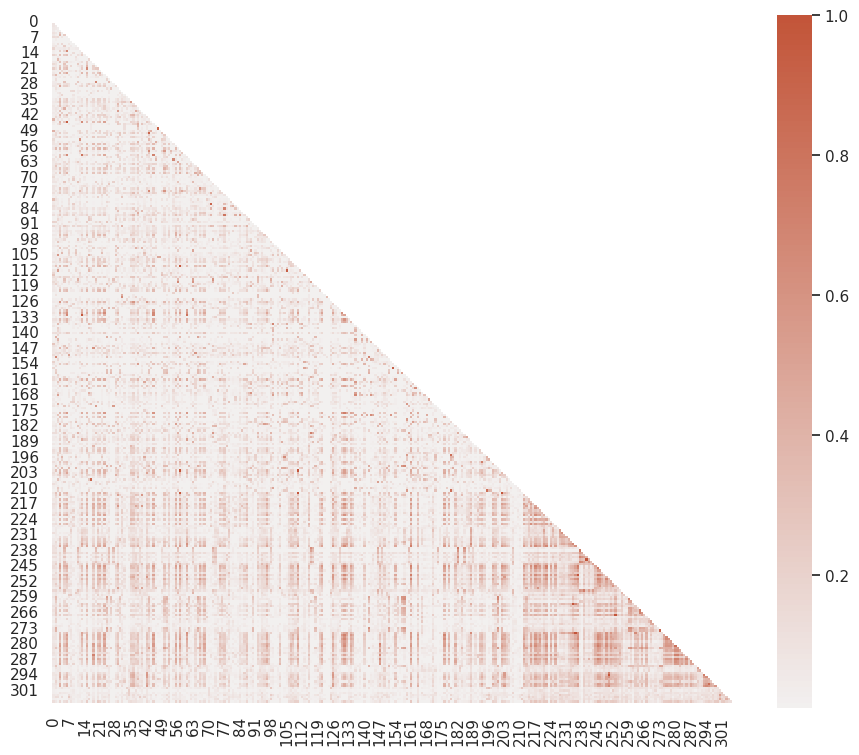

In [185]:
# Configure seaborn
sns.set_theme(style="white")
mask = np.triu(np.ones_like(sim_df, dtype=bool))
_, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Plot a similarity heat map
sns.heatmap(sim_df, mask=mask, cmap=cmap, vmin=0.01, vmax=1, center=0,
            square=True)
#plt.savefig('similarity_heatmap.png', dpi=200, bbox_inches = "tight")


<div class="alert alert-block alert-info">
<img style="float: left" src="https://i.imgur.com/HVpiyd6.png[/img" width="60">
<b style = "font-family: Arial; font-size: 16px">Results:</b><p style = "font-family:Verdana; font-size:14px">
    
As we can see from the heatmap; there are many hot spots, which means many courses are similar to each other. Such patterns suggest that it is possible to build a recommender system based on course similarities.</p> 

In [186]:
course_df

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,ML0201EN,robots are coming build iot apps with watson ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,ML0122EN,accelerating deep learning with gpu,0,1,0,0,0,1,0,1,0,0,0,0,0,0
2,GPXX0ZG0EN,consuming restful services using the reactive ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,RP0105EN,analyzing big data in r using apache spark,1,0,0,1,0,0,0,0,1,0,1,0,0,0
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,0,0,0,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,excourse89,javascript jquery and json,0,0,0,0,0,0,0,0,0,0,0,1,1,0
303,excourse90,programming foundations with javascript html ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
304,excourse91,front end web development with react,0,0,0,0,0,0,0,0,0,0,0,0,1,0
305,excourse92,introduction to web development,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [187]:
bow_df

,doc_index,doc_id,token,bow
0,0,ML0201EN,ai,2
1,0,ML0201EN,apps,2
2,0,ML0201EN,build,2
3,0,ML0201EN,cloud,1
4,0,ML0201EN,coming,1
...,...,...,...,...
10358,306,excourse93,modifying,1
10359,306,excourse93,objectives,1
10360,306,excourse93,pieces,1
10361,306,excourse93,plugins,1


Create an index to id mapping and another id to index mapping in two Python dictionaries:

In [188]:
# Create course id to index and index to id mappings
def get_doc_dicts(bow_df):
    grouped_df = bow_df.groupby(['doc_index', 'doc_id']).max().reset_index(drop=False)
    idx_id_dict = grouped_df[['doc_id']].to_dict()['doc_id']
    id_idx_dict = {v: k for k, v in idx_id_dict.items()}
    del grouped_df
    return idx_id_dict, id_idx_dict

In [189]:
course1 = course_df[course_df['COURSE_ID'] == "ML0151EN"]
course1

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
200,ML0151EN,machine learning with r,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [190]:
course2 = course_df[course_df['COURSE_ID'] == "ML0101ENv3"]
course2

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
158,ML0101ENv3,machine learning with python,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [191]:
idx_id_dict, id_idx_dict = get_doc_dicts(bow_df)
idx1 = id_idx_dict["ML0151EN"]
idx2 = id_idx_dict["ML0101ENv3"]
print(f"Course 1's index is {idx1} and Course 2's index is {idx2}")

Course 1's index is 200 and Course 2's index is 158


In [192]:
sim_matrix = sim_df.to_numpy()

In [193]:
sim = sim_matrix[idx1][idx2]
sim

0.6626221399549089

<h3><a id="Sea_1">Search courses which are similar enough to your enrolled courses.</a></h3> 

Let's assume you are an end-user of the online course platform and **already audited or completed some courses previously**. Next, you expect **the system would recommend similar courses based on your enrollments history**.

In [194]:
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)
course_df[['COURSE_ID', 'TITLE']]

,COURSE_ID,TITLE
0,ML0201EN,robots are coming build iot apps with watson swift and node red
1,ML0122EN,accelerating deep learning with gpu
2,GPXX0ZG0EN,consuming restful services using the reactive jax rs client
3,RP0105EN,analyzing big data in r using apache spark
4,GPXX0Z2PEN,containerizing packaging and running a spring boot application
5,CNSC02EN,cloud native security conference data security
6,DX0106EN,data science bootcamp with r for university proffesors
7,GPXX0FTCEN,learn how to use docker containers for iterative development
8,RAVSCTEST1,scorm test course
9,GPXX06RFEN,create your first mongodb database


In [195]:
# Reset pandas settings
pd.reset_option('display.max_rows')
pd.reset_option('max_colwidth')

In [196]:
enrolled_course_ids = course_df['COURSE_ID'][0:20] # add your interested coures id to the list: top 20

In [197]:
enrolled_courses = course_df[course_df['COURSE_ID'].isin(enrolled_course_ids)]#coures id to the list: top 20
enrolled_courses

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,ML0201EN,robots are coming build iot apps with watson ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,ML0122EN,accelerating deep learning with gpu,0,1,0,0,0,1,0,1,0,0,0,0,0,0
2,GPXX0ZG0EN,consuming restful services using the reactive ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,RP0105EN,analyzing big data in r using apache spark,1,0,0,1,0,0,0,0,1,0,1,0,0,0
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,0,0,0,0,1,0,0,0,0,0,0,1,0,0
5,CNSC02EN,cloud native security conference data security,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,DX0106EN,data science bootcamp with r for university pr...,0,0,0,0,0,0,0,1,0,0,1,0,0,0
7,GPXX0FTCEN,learn how to use docker containers for iterati...,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,RAVSCTEST1,scorm test course,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,GPXX06RFEN,create your first mongodb database,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Given the full course list, we can find those unselected courses:

In [198]:
all_courses = set(course_df['COURSE_ID'])

In [199]:
unselected_course_ids = all_courses.difference(enrolled_course_ids)
unselected_course_ids

{'AI0111EN',
 'BC0101EN',
 'BC0201EN',
 'BC0202EN',
 'BD0101EN',
 'BD0111EN',
 'BD0115EN',
 'BD0121EN',
 'BD0123EN',
 'BD0131EN',
 'BD0133EN',
 'BD0135EN',
 'BD0137EN',
 'BD0141EN',
 'BD0143EN',
 'BD0151EN',
 'BD0153EN',
 'BD0211EN',
 'BD0212EN',
 'BD0221EN',
 'BD0223EN',
 'BENTEST4',
 'CB0101EN',
 'CB0103EN',
 'CB0105ENv1',
 'CB0201EN',
 'CC0101EN',
 'CC0103EN',
 'CC0120EN',
 'CC0121EN',
 'CC0150EN',
 'CC0201EN',
 'CC0210EN',
 'CC0250EN',
 'CL0101EN',
 'CO0101EN',
 'CO0193EN',
 'CO0201EN',
 'CO0301EN',
 'CO0302EN',
 'CO0401EN',
 'COM001EN',
 'CP0101EN',
 'DA0101EN',
 'DA0151EN',
 'DA0201EN',
 'DB0101EN',
 'DB0111EN',
 'DB0113EN',
 'DB0115EN',
 'DB0151EN',
 'DE0205EN',
 'DJ0101EN',
 'DP0101EN',
 'DS0101EN',
 'DS0103EN',
 'DS0105EN',
 'DS0107',
 'DS0110EN',
 'DS0132EN',
 'DS0201EN',
 'DS0301EN',
 'DS0321EN',
 'DV0101EN',
 'DV0151EN',
 'DW0101EN',
 'DX0107EN',
 'EE0101EN',
 'GPXX01AVEN',
 'GPXX01DCEN',
 'GPXX01RYEN',
 'GPXX03HFEN',
 'GPXX0435EN',
 'GPXX048OEN',
 'GPXX04HEEN',
 'GPXX04MXE

In [200]:
def generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix):
    # Create a dictionary to store your recommendation results
    res = {}
    threshold = 0.6
    for enrolled_course in enrolled_course_ids:
        for unselect_course in unselected_course_ids:
            if enrolled_course in id_idx_dict and unselect_course in id_idx_dict:

                sim = 0
                # Find the two indices for each enrolled_course and unselect_course, based on their two ids
                # Calculate the similarity between an enrolled_course and an unselect_course
                # e.g., Course ML0151EN's index is 200 and Course ML0101ENv3's index is 158
                idx1 = id_idx_dict[enrolled_course]
                idx2 = id_idx_dict[unselect_course]

                # Find the similarity value from the sim_matrix
                # sim = sim_matrix[200][158]
                sim = sim_matrix[idx1][idx2]

                if sim > threshold:
                    if unselect_course not in res:
                        res[unselect_course] = sim
                    else:
                        if sim >= res[unselect_course]:
                            res[unselect_course] = sim

    # Sort the results by similarity
    res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}
    return res

In [201]:
idx1

200

In [202]:
generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix)

{'DX0107EN': 0.9797958971132712,
 'TMP0106': 0.9476225544736294,
 'GPXX0JLHEN': 0.8778664812723286,
 'TMP107': 0.7999999999999999,
 'excourse72': 0.7036476305124202,
 'HCC104EN': 0.6831300510639732,
 'ML0122ENv3': 0.6815739441431503,
 'DS0132EN': 0.6689936080056725,
 'WA0101EN': 0.6311528416041716,
 'BD0101EN': 0.623543584505046,
 'DS0110EN': 0.6064784348631227}

In [203]:
# Assuming generate_recommendations_for_one_user is a function
result_dict = generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix)  # Call the function to get the result

# Convert the dictionary to a DataFrame
df_rec_one_user = pd.DataFrame(list(result_dict.items()), columns=['Course_ID', 'Similarity'])

# Sort the DataFrame by similarity
df_rec_one_user = df_rec_one_user.sort_values(by='Similarity', ascending=False)

In [204]:
df_rec_one_user

,Course_ID,Similarity
0,DX0107EN,0.979796
1,TMP0106,0.947623
2,GPXX0JLHEN,0.877866
3,TMP107,0.800000
4,excourse72,0.703648
5,HCC104EN,0.683130
6,ML0122ENv3,0.681574
7,DS0132EN,0.668994
8,WA0101EN,0.631153
9,BD0101EN,0.623544


In [205]:
#def generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix):
    # Create a dictionary to store your recommendation results
    #res = {}
    #threshold = 0.6

    #for enrolled_course in enrolled_course_ids:
        #if enrolled_course not in id_idx_dict:
            #continue

        #idx1 = id_idx_dict[enrolled_course]

        #for unselect_course in unselected_course_ids:
            #if unselect_course in id_idx_dict:
                #idx2 = id_idx_dict[unselect_course]

                # Find the similarity value from the sim_matrix
                #sim = sim_matrix[idx1][idx2]

                #if sim > threshold:
                    #res[unselect_course] = max(sim, res.get(unselect_course, 0))

    # Convert the dictionary to a DataFrame
    #df_rec_one_user = pd.DataFrame(list(res.items()), columns=['Course_ID', 'Similarity'])

    # Sort the DataFrame by similarity
    #df_rec_one_user = df_rec_one_user.sort_values(by='Similarity', ascending=False)

    #return df_rec_one_user

In [206]:
#generate_recommendations_for_one_user(enrolled_courses['COURSE_ID'], unselected_course_ids, id_idx_dict, sim_matrix)

<h3><a id="Sea_2">Generate course recommendations based on course similarities for all (1000) test users.</a></h3> 


Now, let's try to make recommendations for all the test users in the test dataset.


In [207]:
test_users_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/rs_content_test.csv"
test_users_df = pd.read_csv(test_users_url)

In [208]:
test_users_df.head()

,user,item,rating
0,1502801,RP0105EN,3.0
1,1609720,CNSC02EN,2.0
2,1347188,CO0301EN,3.0
3,755067,ML0103EN,3.0
4,538595,BD0115EN,3.0


In [209]:
ratings_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [210]:
test_users_df.equals(ratings_df)

False

In [211]:
test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
test_user_ids = test_users['user'].to_list()
print(f"Total numbers of test users {len(test_user_ids)}")

Total numbers of test users 1000


In [212]:
ratings = ratings_df.groupby(['user']).max().reset_index(drop=False)
ratings_ids = ratings['user'].to_list()
print(f"Total numbers of test users {len(ratings_ids)}")

Total numbers of test users 33901


In [213]:
# WRITE YOUR CODE HERE
def generate_recommendations_for_all():
    users = []
    courses = []
    sim_scores = []
    # Test user dataframe
    # Course similarity matrix
    sim_df #= pd.read_csv(sim_url)
    sim_matrix = sim_df.to_numpy()
    # Course content dataframe
    course_df #= pd.read_csv(course_url)
    # Course BoW features
    bow_df #= pd.read_csv(bow_url)
    test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    test_user_ids = test_users['user'].to_list()

    # ...

    for user_id in test_user_ids:
        idx_id_dict, id_idx_dict = get_doc_dicts(bow_df)

        enrolled_course_ids = test_users_df[test_users_df['user'] == 1078030]['item'].to_numpy()
        all_courses = set(course_df['COURSE_ID'])
        unselected_course_ids = all_courses.difference(enrolled_course_ids)

        course_score_dict = generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix)
        # For each user, call generate_recommendations_for_one_user() to generate the recommendation results
        # Save the result to courses, sim_scores list
        for k, v in course_score_dict.items():
            users.append(user_id)
            courses.append(k)
            sim_scores.append(v)

    return users, courses, sim_scores

In [214]:
res_dict = {}
users, courses, sim_scores = generate_recommendations_for_all()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = sim_scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
# Save the dataframe 
res_df.to_csv("profile_rs_results_course_similarities.csv", index=False)

In [215]:
res_df.head()

,USER,COURSE_ID,SCORE
0,37465,ML0120ENv3,1.000000
1,37465,ML0120EN,1.000000
2,37465,excourse36,0.739704
3,37465,excourse23,0.739704
4,37465,DV0151EN,0.723536


In [216]:
res_df

,USER,COURSE_ID,SCORE
0,37465,ML0120ENv3,1.000000
1,37465,ML0120EN,1.000000
2,37465,excourse36,0.739704
3,37465,excourse23,0.739704
4,37465,DV0151EN,0.723536
...,...,...,...
15995,2087663,excourse62,0.647502
15996,2087663,excourse47,0.634755
15997,2087663,excourse60,0.615568
15998,2087663,excourse46,0.612054


In [217]:
res_df.head(10)

,USER,COURSE_ID,SCORE
0,37465,ML0120ENv3,1.000000
1,37465,ML0120EN,1.000000
2,37465,excourse36,0.739704
3,37465,excourse23,0.739704
4,37465,DV0151EN,0.723536
5,37465,excourse32,0.722018
6,37465,ML0122ENv3,0.707107
7,37465,excourse38,0.681638
8,37465,excourse33,0.664509
9,37465,ML0151EN,0.662622


In [218]:
res_df['USER'].nunique()

1000

In [219]:
res_df['COURSE_ID'].nunique()

16

In [220]:
res_merge_df = pd.merge(res_df, course_df[['COURSE_ID', 'TITLE']], how='left', on='COURSE_ID')

In [221]:
res_merge_df.head(10)

,USER,COURSE_ID,SCORE,TITLE
0,37465,ML0120ENv3,1.000000,deep learning with tensorflow
1,37465,ML0120EN,1.000000,deep learning with tensorflow
2,37465,excourse36,0.739704,data analysis using python
3,37465,excourse23,0.739704,data analysis using python
4,37465,DV0151EN,0.723536,data visualization with r
5,37465,excourse32,0.722018,introduction to data analytics
6,37465,ML0122ENv3,0.707107,accelerating deep learning with gpus
7,37465,excourse38,0.681638,data analysis with python
8,37465,excourse33,0.664509,excel basics for data analysis
9,37465,ML0151EN,0.662622,machine learning with r


In [222]:
res_merge_df['COURSE_ID'].head(10).nunique()

10

<h3><a id="Res_2">Result course recommendation for 3 users based on course similarity</a></h3>

### User 1078030

In [223]:
res_merge_df[res_merge_df['USER'] == 1078030]

,USER,COURSE_ID,SCORE,TITLE
7984,1078030,ML0120ENv3,1.000000,deep learning with tensorflow
7985,1078030,ML0120EN,1.000000,deep learning with tensorflow
7986,1078030,excourse36,0.739704,data analysis using python
7987,1078030,excourse23,0.739704,data analysis using python
7988,1078030,DV0151EN,0.723536,data visualization with r
7989,1078030,excourse32,0.722018,introduction to data analytics
7990,1078030,ML0122ENv3,0.707107,accelerating deep learning with gpus
7991,1078030,excourse38,0.681638,data analysis with python
7992,1078030,excourse33,0.664509,excel basics for data analysis
7993,1078030,ML0151EN,0.662622,machine learning with r


In [224]:
res_merge_df[res_merge_df['USER'] == 1078030].head(10)

,USER,COURSE_ID,SCORE,TITLE
7984,1078030,ML0120ENv3,1.000000,deep learning with tensorflow
7985,1078030,ML0120EN,1.000000,deep learning with tensorflow
7986,1078030,excourse36,0.739704,data analysis using python
7987,1078030,excourse23,0.739704,data analysis using python
7988,1078030,DV0151EN,0.723536,data visualization with r
7989,1078030,excourse32,0.722018,introduction to data analytics
7990,1078030,ML0122ENv3,0.707107,accelerating deep learning with gpus
7991,1078030,excourse38,0.681638,data analysis with python
7992,1078030,excourse33,0.664509,excel basics for data analysis
7993,1078030,ML0151EN,0.662622,machine learning with r


### User 733707

In [225]:
res_merge_df[res_merge_df['USER'] == 733707]

,USER,COURSE_ID,SCORE,TITLE
4128,733707,ML0120ENv3,1.000000,deep learning with tensorflow
4129,733707,ML0120EN,1.000000,deep learning with tensorflow
4130,733707,excourse36,0.739704,data analysis using python
4131,733707,excourse23,0.739704,data analysis using python
4132,733707,DV0151EN,0.723536,data visualization with r
4133,733707,excourse32,0.722018,introduction to data analytics
4134,733707,ML0122ENv3,0.707107,accelerating deep learning with gpus
4135,733707,excourse38,0.681638,data analysis with python
4136,733707,excourse33,0.664509,excel basics for data analysis
4137,733707,ML0151EN,0.662622,machine learning with r


In [226]:
res_merge_df[res_merge_df['USER'] == 733707].head(10)

,USER,COURSE_ID,SCORE,TITLE
4128,733707,ML0120ENv3,1.000000,deep learning with tensorflow
4129,733707,ML0120EN,1.000000,deep learning with tensorflow
4130,733707,excourse36,0.739704,data analysis using python
4131,733707,excourse23,0.739704,data analysis using python
4132,733707,DV0151EN,0.723536,data visualization with r
4133,733707,excourse32,0.722018,introduction to data analytics
4134,733707,ML0122ENv3,0.707107,accelerating deep learning with gpus
4135,733707,excourse38,0.681638,data analysis with python
4136,733707,excourse33,0.664509,excel basics for data analysis
4137,733707,ML0151EN,0.662622,machine learning with r


In [227]:
res_merge_df[res_merge_df['USER'] == 733707]['COURSE_ID'].head(10).values

array(['ML0120ENv3', 'ML0120EN', 'excourse36', 'excourse23', 'DV0151EN',
       'excourse32', 'ML0122ENv3', 'excourse38', 'excourse33', 'ML0151EN'],
      dtype=object)

In [228]:
(res_merge_df[res_merge_df['USER'] == 733707]['COURSE_ID'].head(10).values == res_merge_df[res_merge_df['USER'] == 1078030]['COURSE_ID'].head(10).values).all()

True

### User 674939

In [229]:
res_merge_df[res_merge_df['USER'] == 674939]

,USER,COURSE_ID,SCORE,TITLE
3328,674939,ML0120ENv3,1.000000,deep learning with tensorflow
3329,674939,ML0120EN,1.000000,deep learning with tensorflow
3330,674939,excourse36,0.739704,data analysis using python
3331,674939,excourse23,0.739704,data analysis using python
3332,674939,DV0151EN,0.723536,data visualization with r
3333,674939,excourse32,0.722018,introduction to data analytics
3334,674939,ML0122ENv3,0.707107,accelerating deep learning with gpus
3335,674939,excourse38,0.681638,data analysis with python
3336,674939,excourse33,0.664509,excel basics for data analysis
3337,674939,ML0151EN,0.662622,machine learning with r


In [230]:
(res_merge_df[res_merge_df['USER'] == 674939]['COURSE_ID'].head(10).values == res_merge_df[res_merge_df['USER'] == 1078030]['COURSE_ID'].head(10).values).all()

True

### Rating 2

In [231]:
res_merge_df[res_merge_df['USER'] == 2057052]['COURSE_ID'].head(10).values

array(['ML0120ENv3', 'ML0120EN', 'excourse36', 'excourse23', 'DV0151EN',
       'excourse32', 'ML0122ENv3', 'excourse38', 'excourse33', 'ML0151EN'],
      dtype=object)

In [232]:
(res_merge_df[res_merge_df['USER'] == 2057052]['COURSE_ID'].head(10).values == res_merge_df[res_merge_df['USER'] == 1078030]['COURSE_ID'].head(10).values).all()

True

### Insert the user in the Class Code
### User 733707 

In [233]:
# WRITE YOUR CODE HERE
def generate_recommendations_for_all():
    users = []
    courses = []
    sim_scores = []
    # Test user dataframe
    # Course similarity matrix
    sim_df #= pd.read_csv(sim_url)
    sim_matrix = sim_df.to_numpy()
    # Course content dataframe
    course_df #= pd.read_csv(course_url)
    # Course BoW features
    bow_df #= pd.read_csv(bow_url)
    test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    test_user_ids = test_users['user'].to_list()

    # ...

    for user_id in test_user_ids:
        idx_id_dict, id_idx_dict = get_doc_dicts(bow_df)

        enrolled_course_ids = test_users_df[test_users_df['user'] == 733707]['item'].to_numpy()
        all_courses = set(course_df['COURSE_ID'])
        unselected_course_ids = all_courses.difference(enrolled_course_ids)

        course_score_dict = generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix)
        # For each user, call generate_recommendations_for_one_user() to generate the recommendation results
        # Save the result to courses, sim_scores list
        for k, v in course_score_dict.items():
            users.append(user_id)
            courses.append(k)
            sim_scores.append(v)

    return users, courses, sim_scores

In [234]:
# set the threshold globally
#threshold = 0.4

#def generate_recommendations_for_all(threshold):
    #users = []
    #courses = []
    #sim_scores = []
    # Test user dataframe
    # Course similarity matrix
    #sim_df #= pd.read_csv(sim_url)
    #sim_matrix = sim_df.to_numpy()
    # Course content dataframe
    #course_df #= pd.read_csv(course_url)
    # Course BoW features
    #bow_df #= pd.read_csv(bow_url)
    #test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    #test_user_ids = test_users['user'].to_list()

    # ...

    #for user_id in test_user_ids:
        #idx_id_dict, id_idx_dict = get_doc_dicts(bow_df)

        #enrolled_course_ids = test_users_df[test_users_df['user'] == 733707]['item'].to_numpy()
        #all_courses = set(course_df['COURSE_ID'])
        #unselected_course_ids = all_courses.difference(enrolled_course_ids)

        #course_score_dict = generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix)
        # For each user, call generate_recommendations_for_one_user() to generate the recommendation results
        # Save the result to courses, sim_scores list
        #for k, v in course_score_dict.items():
            #users.append(user_id)
            #courses.append(k)
            #sim_scores.append(v)

    #return users, courses, sim_scores

In [236]:
res_dict = {}
users, courses, sim_scores = generate_recommendations_for_all() #generate_recommendations_for_all(threshold)
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = sim_scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
# Save the dataframe 
res_df.to_csv("profile_rs_results_course_similarities_2.csv", index=False)

In [237]:
res_df.head(10)

,USER,COURSE_ID,SCORE
0,37465,ML0120ENv2,1.000000
1,37465,ML0120ENv3,1.000000
2,37465,ML0122ENv1,0.982873
3,37465,DS0110EN,0.732941
4,37465,excourse67,0.708214
5,37465,excourse72,0.703648
6,37465,excourse63,0.694563
7,37465,excourse46,0.689253
8,37465,excourse47,0.680065
9,37465,ML0101ENv3,0.662622


In [238]:
res_df['COURSE_ID'].nunique()

15

In [239]:
res_merge_2_df = pd.merge(res_df, course_df[['COURSE_ID', 'TITLE']], how='left', on='COURSE_ID')

In [240]:
res_merge_2_df[res_merge_2_df['USER'] == 733707]['COURSE_ID'].head(10).values

array(['ML0120ENv2', 'ML0120ENv3', 'ML0122ENv1', 'DS0110EN', 'excourse67',
       'excourse72', 'excourse63', 'excourse46', 'excourse47',
       'ML0101ENv3'], dtype=object)

In [241]:
res_merge_2_df[res_merge_2_df['USER'] == 733707].head(10)

,USER,COURSE_ID,SCORE,TITLE
3870,733707,ML0120ENv2,1.000000,deep learning with tensorflow
3871,733707,ML0120ENv3,1.000000,deep learning with tensorflow
3872,733707,ML0122ENv1,0.982873,accelerating deep learning with gpu
3873,733707,DS0110EN,0.732941,data science with open data
3874,733707,excourse67,0.708214,introduction to big data
3875,733707,excourse72,0.703648,foundations for big data analysis with sql
3876,733707,excourse63,0.694563,a crash course in data science
3877,733707,excourse46,0.689253,machine learning
3878,733707,excourse47,0.680065,machine learning for all
3879,733707,ML0101ENv3,0.662622,machine learning with python


In [242]:
(res_merge_df[res_merge_df['USER'] == 733707]['COURSE_ID'].head(10).values == res_merge_2_df[res_merge_2_df['USER'] == 733707]['COURSE_ID'].head(10).values).all()

False

### User 674939

In [243]:
# WRITE YOUR CODE HERE
def generate_recommendations_for_all():
    users = []
    courses = []
    sim_scores = []
    # Test user dataframe
    # Course similarity matrix
    sim_df #= pd.read_csv(sim_url)
    sim_matrix = sim_df.to_numpy()
    # Course content dataframe
    course_df #= pd.read_csv(course_url)
    # Course BoW features
    bow_df #= pd.read_csv(bow_url)
    test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    test_user_ids = test_users['user'].to_list()

    # ...

    for user_id in test_user_ids:
        idx_id_dict, id_idx_dict = get_doc_dicts(bow_df)

        enrolled_course_ids = test_users_df[test_users_df['user'] == 674939]['item'].to_numpy()
        all_courses = set(course_df['COURSE_ID'])
        unselected_course_ids = all_courses.difference(enrolled_course_ids)

        course_score_dict = generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix)
        # For each user, call generate_recommendations_for_one_user() to generate the recommendation results
        # Save the result to courses, sim_scores list
        for k, v in course_score_dict.items():
            users.append(user_id)
            courses.append(k)
            sim_scores.append(v)

    return users, courses, sim_scores

In [244]:
res_dict = {}
users, courses, sim_scores = generate_recommendations_for_all()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = sim_scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
# Save the dataframe 
res_df.to_csv("profile_rs_results_course_similarities_3.csv", index=False)

In [245]:
res_df.head(10)

,USER,COURSE_ID,SCORE
0,37465,excourse67,0.708214
1,37465,excourse72,0.703648
2,37465,excourse74,0.650071
3,37465,excourse68,0.616759
4,50348,excourse67,0.708214
5,50348,excourse72,0.703648
6,50348,excourse74,0.650071
7,50348,excourse68,0.616759
8,52091,excourse67,0.708214
9,52091,excourse72,0.703648


In [246]:
res_df['COURSE_ID'].nunique()

4

In [247]:
res_merge_3_df = pd.merge(res_df, course_df[['COURSE_ID', 'TITLE']], how='left', on='COURSE_ID')

In [248]:
res_merge_3_df[res_merge_3_df['USER'] == 674939].head(10)

,USER,COURSE_ID,SCORE,TITLE
832,674939,excourse67,0.708214,introduction to big data
833,674939,excourse72,0.703648,foundations for big data analysis with sql
834,674939,excourse74,0.650071,fundamentals of big data
835,674939,excourse68,0.616759,big data modeling and management systems


In [249]:
#(res_merge_df[res_merge_df['USER'] == 674939]['COURSE_ID'].head(10).values == res_merge_3_df[res_merge_3_df['USER'] == 674939]['COURSE_ID'].head(10).values).all()
# Extracting the course IDs for the two DataFrames
courses_df1 = res_merge_df[res_merge_df['USER'] == 674939]['COURSE_ID'].head(10).values
courses_df2 = res_merge_3_df[res_merge_3_df['USER'] == 674939]['COURSE_ID'].head(10).values

# Comparing the two arrays directly
are_equal = np.array_equal(courses_df1, courses_df2)

# Displaying the result
print(are_equal)

False


### Rating 2

In [250]:
# WRITE YOUR CODE HERE
def generate_recommendations_for_all():
    users = []
    courses = []
    sim_scores = []
    # Test user dataframe
    # Course similarity matrix
    sim_df #= pd.read_csv(sim_url)
    sim_matrix = sim_df.to_numpy()
    # Course content dataframe
    course_df #= pd.read_csv(course_url)
    # Course BoW features
    bow_df #= pd.read_csv(bow_url)
    test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    test_user_ids = test_users['user'].to_list()

    # ...

    for user_id in test_user_ids:
        idx_id_dict, id_idx_dict = get_doc_dicts(bow_df)

        enrolled_course_ids = test_users_df[test_users_df['user'] == 2057052]['item'].to_numpy()
        all_courses = set(course_df['COURSE_ID'])
        unselected_course_ids = all_courses.difference(enrolled_course_ids)

        course_score_dict = generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix)
        # For each user, call generate_recommendations_for_one_user() to generate the recommendation results
        # Save the result to courses, sim_scores list
        for k, v in course_score_dict.items():
            users.append(user_id)
            courses.append(k)
            sim_scores.append(v)

    return users, courses, sim_scores

In [251]:
res_dict = {}
users, courses, sim_scores = generate_recommendations_for_all()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = sim_scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
# Save the dataframe 
res_df.to_csv("profile_rs_results_course_similarities_3.csv", index=False)

In [252]:
res_df.head(10)

,USER,COURSE_ID,SCORE
0,37465,DS0110EN,0.732941
1,37465,excourse63,0.694563
2,37465,DAI101EN,0.668994
3,37465,ML0151EN,0.662622
4,37465,excourse22,0.647502
5,37465,excourse62,0.647502
6,37465,excourse65,0.638641
7,37465,excourse47,0.634755
8,37465,excourse46,0.612054
9,50348,DS0110EN,0.732941


In [253]:
res_df['COURSE_ID'].nunique()

9

In [254]:
res_merge_4_df = pd.merge(res_df, course_df[['COURSE_ID', 'TITLE']], how='left', on='COURSE_ID')

In [255]:
res_merge_4_df[res_merge_4_df['USER'] == 2057052].head(10)

,USER,COURSE_ID,SCORE,TITLE
8946,2057052,DS0110EN,0.732941,data science with open data
8947,2057052,excourse63,0.694563,a crash course in data science
8948,2057052,DAI101EN,0.668994,data ai essentials
8949,2057052,ML0151EN,0.662622,machine learning with r
8950,2057052,excourse22,0.647502,introduction to data science in python
8951,2057052,excourse62,0.647502,introduction to data science in python
8952,2057052,excourse65,0.638641,data science fundamentals for data analysts
8953,2057052,excourse47,0.634755,machine learning for all
8954,2057052,excourse46,0.612054,machine learning


In [256]:
from IPython.display import display, HTML
# Link HTML files for pages
output_file_02 = "https://www.kaggle.com/wahyuardhitama/task003-p002-ml-dl-rec-sys-course-20231029"
output_file_03 = "https://www.kaggle.com/wahyuardhitama/task003-p003-ml-dl-rec-sys-course-20231101"

# Display links to the saved HTML files
display(HTML(f"<p style='font-size: 18px;'>Go to <a href='{output_file_02}' target='_blank' style='font-size: 18px;'>P02 </a>or <a href='{output_file_03}' target='_blank' style='font-size: 18px;'>P03 </a></p>"))

<img style="float:left" src="https://i.imgur.com/wpcEXQC.png" width="50"><div style = "font-family: Arial; font-size: 16px">
    <h1>Execute</h1></div>

# Summary
Depend on our similarity threshold (default is 0.6). A lower similarity threshold yields more recommended courses but with smaller irrelevance.
Ideally, we should limit the maximum course recommendations for each user to be less than 20 courses per user.
<hr>

<div class="alert alert-block alert-success" style="font-family:verdana; font-size:14px">
<ol>The course similarity based on feature vectors - course recommendation results
    <li>Offer personalized suggestions based on the intrinsic characteristics of courses.
    <li>Based on explicit features (e.g., course content) that users can understand.
    <li>Make recommendations even for new users with limited interaction history.
    <li>Based on specific features of courses, allowing users to interpret and understand the reasons behind each recommendation.    
</ol>